## Flatten Observation Space
- Dict to Box 

```python
Flatten the observation space
attack_obs_space = env.observation_space
pprint(attack_obs_space.__repr__)
flatten_space(attack_obs_space)                                       # Box in (30, )

test_sample = flatten(attack_obs_space, attack_obs_space.sample())    # array in (30,)
ans = unflatten(attack_obs_space, test_sample)                        # OrderedDict

obs_space = env.observation_space
obs_space['defender']

flatten_space(obs_space['defender'])                                       # Box in (30, )

test_sample = flatten(obs_space['defender'], obs_space['defender'].sample())    # array in (30,)

ans = unflatten(obs_space['defender'], test_sample)                        # OrderedDict
```


In [ ]:
from pprint import pprint
import gym
import gym_cyberwargame
import random
from gym.spaces.utils import flatten_space, flatten, unflatten
from gym_cyberwargame.envs.cyberwargame_env_multiagent import env
import numpy as np

"""
for i_episode in range(2):
    observation = env.reset()
    for t in range(20):
        # env.render()
        # print(observation)
        # action = env.attacker_action_space.sample()
        # action = env.action_space.sample()
        test_src = random.randint(1,3)
        action = [1,test_src]
        # print(action)
        observation, reward, done, info = env.step(action)
        if done:
            print("=========Episode finished after {} timesteps=========".format(t+1))
            break
""" 
# Pure env 
# env = gym.make('gym_cyberwargame/CyberWarGame-v0')
# PettingZoo Version


cbw_env = env()

def print_env_info(env):
    attacker_observation_space = cbw_env.observation_space("attacker")
    defender_observation_space = cbw_env.observation_space("defender")

    a_action_space = cbw_env.action_space("attacker")
    d_action_space = cbw_env.action_space("defender")
    test_sample = a_action_space.sample()
    f_a_action_space = flatten_space(a_action_space)
    # test_sample = a_action_space.sample()
    f_attack = flatten(a_action_space, test_sample)
    reverse_action = unflatten(a_action_space,f_attack)
    # unflatten_attack = unflatten
    equal = reverse_action == test_sample


    print("1. attacker_observation_space\n {}\n".format(attacker_observation_space))
    print("2. defender_observation_space\n {}\n".format(defender_observation_space))
    print("3. attack_action_space\n {}\n".format(a_action_space))
    print("4. defender_action_space\n {}\n".format(d_action_space))

    print("5. flatten action space \n {}\n".format(f_a_action_space))
    print("6. flatten action sample with {} \n {}\n".format(test_sample, f_attack))
    print("7. unflatten action space \n {}\n".format(reverse_action))
    print("8. flatten revsere equal? \n {}\n".format(equal))
    print("9. flatten revsere equal? \n {}\n".format(a_action_space==d_action_space))

    for i in range(1000):
        test_sample = np.random.randint(0, 5)
        f_attack = flatten(a_action_space, test_sample)
        reverse_action = unflatten(a_action_space, f_attack)
        # print("9. flatten test for \n {} to: {}\n".format(test_sample, reverse_action))
        assert reverse_action == test_sample, ("Test Error")

    print("10. attacker_action_map", cbw_env.attacker_action_map)
    print("11. defender action sample", cbw_env.action_space("defender").sample())
    print("11. defender action sample", cbw_env.action_space("defender").__class__)

print_env_info(env=cbw_env)


In [ ]:
from gym import spaces
a = spaces.MultiDiscrete([10,10])
valid_samples = [[0,0], [1,0], [0,1], [1,1]]
import numpy as np
from tianshou.env.gym_wrappers import MultiDiscreteToDiscrete
# this works
# for i in range(100):
#     sample = a.sample()
#     assert list(sample) in valid_samples, "{} is not a valid sample of {}".format(sample, valid_samples)

af = spaces.flatten_space(a)
# this will fail because a sample will be drawn with a value of 2 in one of the elements
for i in range(1):
    flat_sample = af.sample()
    # assert list(flat_sample) in valid_samples, "{} is not a valid sample of {}".format(flat_sample, valid_samples)
    af_array = spaces.flatten(a, np.array([0,0]))
    reverse_array = spaces.unflatten(a, af_array)
    print("Before flatten {}".format(af_array))
    print("After flatten {}".format(reverse_array))
# np.random.choice(100, 2)
attack_list = [10, 10, 10, 10]
multi_a = spaces.Box(low=np.array([0]*4), high=np.array([10] + [0]*3), shape=(4, ), dtype=np.int32)
test_sample = multi_a.sample()
new_action_space = spaces.Discrete(np.prod(attack_list))
test = np.ones_like(multi_a)
print(multi_a.sample())

In [ ]:
import numpy as np
from collections import  defaultdict

test = np.array([[1,3,4], [2,43,4], [1,100,4]])
dict_test = defaultdict(list)
dict_test['1'] = [0, 0]
dict_test['2'] = [0, 0]
for i in test:
    dict_test[str(i[0])][0] += i[1]
    dict_test[str(i[0])][1] += 1
print(dict_test)

## Wrapper Environment Test

In [ ]:
from supersuit import pad_observations_v0, pad_action_space_v0
cbw_env_pz = env()
pd_env = pad_observations_v0(cbw_env_pz)
pd_env = pad_action_space_v0(pd_env)
print_env_info(pd_env)
pd_env.action_spaces

# Q-Learning Test

In [ ]:
import sys
from pathlib import Path
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path) # 添加路径到系统路径

import gym
import gym_cyberwargame
import torch
import math
import datetime
import numpy as np
from collections import defaultdict
from envs.gridworld_env import CliffWalkingWapper
import gym_cyberwargame
from QLearning.agent import QLearning
from common.utils import plot_rewards
from common.utils import save_results, make_dir
from gym.spaces.utils import flatten_space, flatten, unflatten



class QLearning(object):
    def __init__(self,state_dim,
                 action_dim,cfg):
        self.action_dim = action_dim 
        self.lr = cfg.lr  # 学习率
        self.gamma = cfg.gamma  
        self.epsilon = 0 
        self.sample_count = 0  
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table  = defaultdict(lambda: np.zeros(action_dim.shape)) # 用嵌套字典存放状态->动作->状态-动作值（Q值）的映射，即Q表
        # print(str(self.Q_table))
        
    def choose_action(self, state):
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # epsilon是会递减的，这里选择指数递减
        # e-greedy 策略
        # if np.random.uniform(0, 1) > self.epsilon:
        #     action = np.argmax(self.Q_table[str(state)]) # 选择Q(s,a)最大对应的动作
        # else:
        action = np.random.choice(2, 20) # 随机选择动作
        # action = np.array((np.random.choice(self.action_dim[0]), np.random.choice(self.action_dim[1]))) # 随机选择动作
        # action =  {}
        # action['attack_action'] = np.array((np.random.choice(self.action_dim[0]), np.random.choice(self.action_dim[1])))
        # action['defend_action'] = np.random.choice(1)
        print(action)
        return action

    def predict(self,state):
        action = np.argmax(self.Q_table[str(state)])
        return action

    def update(self, state, action, reward, next_state, done):
        Q_predict = self.Q_table[str(state)][action] 
        if done: # 终止状态
            Q_target = reward  
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)]) 
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)
    
    def save(self,path):
        import dill
        torch.save(
            obj=self.Q_table,
            f=path+"Qleaning_model.pkl",
            pickle_module=dill
        )
        print("保存模型成功！")
    def load(self, path):
        import dill
        self.Q_table =torch.load(f=path+'Qleaning_model.pkl',pickle_module=dill)
        print("加载模型成功！")


def train(cfg,env,agent):
    print('开始训练!')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = []  # 记录奖励
    ma_rewards = [] # 记录滑动平均奖励
    for i_ep in range(cfg.train_eps):
        step = 0
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset()  # 重置环境, 重新开一局（即开始新的一个episode）
        # Handle the obs flatten 
        attack_state_flatten = flatten(env.observation_space['attacker'], state['attacker']) 

        while step<300:
            step+=1
            print("attack_state_flatten {}".format(attack_state_flatten))
            action = agent.choose_action(attack_state_flatten)  # 根据算法选择一个动作
            # print("\n==========".join(agent.Q_table))
            print("action: {}".format(action))
            # flatten_action = unflatten(env.action_space['attacker'], action)
            next_state, reward, done, _ = env.step(action)  # 与环境进行一次动作交互
            next_state_flatten = flatten(env.observation_space['attacker'], next_state['attacker']) 
            
            # print("++++++ The chosen action is ", flatten_action)
            agent.update(attack_state_flatten, action, reward, next_state_flatten, done)  # Q-learning算法更新
            attack_state_flatten = next_state_flatten  # 存储上一个观察值
            ep_reward += reward
            if done:
                # for item in agent.Q_table.items():
                #     print("Item is ", item)
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep+1)%20 == 0: 
            print('回合：{}/{}, 奖励：{}'.format(i_ep+1, cfg.train_eps, ep_reward))
    print('完成训练！')
    return rewards,ma_rewards


curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # 获取当前时间
algo_name = 'Q-learning'  # 算法名称
env_name = 'CyberWarGameEnv-v0'  # 环境名称
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 检测GPU
class QlearningConfig:
    '''训练相关参数'''
    def __init__(self):
        self.algo_name = algo_name # 算法名称
        self.env_name = env_name # 环境名称
        self.device = device # 检测GPU
        self.train_eps = 50 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.gamma = 0.9 # reward的衰减率
        self.epsilon_start = 0.95 # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 300 # e-greedy策略中epsilon的衰减率
        self.lr = 0.1 # 学习率      
class PlotConfig:
    ''' 绘图相关参数设置
    '''

    def __init__(self) -> None:
        self.algo_name = algo_name  # 算法名称
        self.env_name = env_name  # 环境名称
        self.device = device # 检测GPU
        self.result_path = curr_path + "/QLearning-outputs/" + self.env_name + \
            '/' + curr_time + '/results/'  # 保存结果的路径
        self.model_path = curr_path + "/QLearning-outputs/" + self.env_name + \
            '/' + curr_time + '/models/'  # 保存模型的路径
        self.save = True  # 是否保存图片


def env_agent_config(cfg,seed=1):
    '''创建环境和智能体
    Args:
        cfg ([type]): [description]
        seed (int, optional): 随机种子. Defaults to 1.
    Returns:
        env [type]: 环境
        agent : 智能体
    '''    
    env = gym.make('gym_cyberwargame/CyberWarGame-v0')
    # env.render()
    # env.seed(seed) # 设置随机种子
    state_dim = env.observation_space # 状态维度
    action_dim = flatten_space(env.action_space['attacker'])    # 动作维度 src_ip + time_interval
    # action_dim = env.attacker_action_space[0].n * env.attacker_action_space[1].n
    agent = QLearning(state_dim,action_dim,cfg)
    return env,agent


cfg = QlearningConfig()
plot_cfg = PlotConfig()
# 训练
env, agent = env_agent_config(cfg, seed=1)
rewards, ma_rewards = train(cfg, env, agent)
make_dir(plot_cfg.result_path, plot_cfg.model_path)  # 创建保存结果和模型路径的文件夹
agent.save(path=plot_cfg.model_path)  # 保存模型
# save_results(rewards, ma_rewards, tag='train',
#             path=plot_cfg.result_path)  # 保存结果
plot_rewards(rewards, ma_rewards, plot_cfg, tag="train")  # 画出结果
env.close()

# Testing with the PettingZoo

In [ ]:
import gym
import gym_cyberwargame
import pettingzoo
from pettingzoo.test import api_test, render_test
from gym_cyberwargame.envs.cyberwargame_env_multiagent import env
from pettingzoo.butterfly import pistonball_v6
import numpy as np  

# env = pistonball_v6.env()

cbw = env()
obs, info = cbw.reset(return_info=True)
print(obs['attacker'])
print(cbw.rewards)
attack_rew = []
defend_rew = []
for i_episode in range(1):
    cbw.reset()
    for step in range(4):
        for agent in cbw.agent_iter(max_iter=2):
            # print("Choosing Agent {}".format(agent))
            observation, reward, done, info = cbw.last()
            if done:
                break
            # print("what is last() {} {} {} {}".format(observation, reward, done, info))
            if agent == 'attacker':
                # print("attacker")
                attack_rew.append(reward)
            else:
                # print("defender")
                defend_rew.append(reward)
            action = None
            if agent == "attacker":
                action = np.random.randint(0, 5)
            elif agent == "defender":
                action = np.random.randint(0, 5)
            cbw.step(action)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(len(attack_rew)), attack_rew, label="attacker")
ax.plot(range(len(defend_rew)), defend_rew, label="defender")
ax.legend()
# print("{}\n{}\n{}\n{}\n".format(obs, reward, done, info))

In [ ]:
import numpy as np
test_array = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]])
# test_array = np.append(test_array, ([[1,3,4]]), axis=0)
print(type(test_array))

# Transfer To Tianshou

In [ ]:
import imp
import gym, torch, numpy as np, torch.nn as nn
import gym_cyberwargame
from torch.utils.tensorboard import SummaryWriter
import tianshou as ts
from gym_cyberwargame.envs.cyberwargame_env_multiagent import env
from tianshou.data import Batch, ReplayBuffer

# Basic API Test for Tianshou
# env = gym.make('gym_cyberwargame/CyberWarGame-v0')
env = env()
obs = env.reset()
# print(obs)

# for agent_id, agent_obs in env.observation_space.items():
#     print(agent_id, "======", agent_obs)

b = ReplayBuffer(size=1)
obs,info=env.reset()
b.add(Batch(obs=obs, act=0, rew=0, done=0))
# print(b)
# print(b.obs.currenet_utilization)
# batch, indices = b.sample(1)
# batch.obs
# action = np.random.choice(2, 20)
# obs, reward, done, info = env.step(action)
print(b)

##  Test One simple Random Agents in DQN
- For Attacker

### Build the network
Problem in:
1. Attacker can not converged. attacker不能收敛
2. 不能分开两个collector进行数据收集，但是两个collector可以指向同一个env操作，只是调用nstep不能顺序执行？
3. preprocess_fn()的返回问题，导致处理过程出错

In [ ]:
from tianshou.policy.modelfree.bdq import BranchingDQNPolicy, DQNPolicy
from tianshou.utils.net.common import BranchingNet
import gym, torch, numpy as np, torch.nn as nn
import gym_cyberwargame
import tianshou as ts
from tianshou.data import Collector, Batch
from tianshou.data import Batch, ReplayBuffer
from tianshou.env import DummyVectorEnv, SubprocVectorEnv
from tianshou.policy import RandomPolicy, MultiAgentPolicyManager
from gym_cyberwargame.envs.cyberwargame_env_multiagent import env
from gym.spaces.utils import flatten_space, flatten, unflatten

from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
import matplotlib.pyplot as plt

# env = gym.make('gym_cyberwargame/CyberWarGame-v0')
cbwenv = env()

train_env = ts.env.DummyVectorEnv([lambda: cbwenv])
test_env = ts.env.DummyVectorEnv([lambda: cbwenv])


class Net(nn.Module):
    def __init__(self, state_shape, action_shape, agent_name):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(np.prod(state_shape), 128), nn.ReLU(inplace=True),
            nn.Linear(128, 128), nn.ReLU(inplace=True),
            nn.Linear(128, 128), nn.ReLU(inplace=True),
            nn.Linear(128, np.prod(action_shape)),
        )
        self.agent = agent_name
    
    def forward(self, batch, state=None, info={}):    # obs is actually Batch
        # print("in forward, batch is {}".format(batch))
        """
            Batch(
        attacker: array([[[ 95,   0,   0],
                          [ 94,   0,   0],
                          [215,   0,   0],
                          [149,   0,   0],
                          [ 24,   0,   0]]], dtype=int64),
        defender: array([[[ 95,   0],
                          [ 94,   0],
        """
        if not isinstance(batch, torch.Tensor):
            if self.agent=="attacker":
                batch = torch.tensor(batch, dtype=torch.float) # [10, 3]
            elif self.agent == "defender":
                batch = torch.tensor(batch, dtype=torch.float) # [10, 3]
        # obs is a batch
        batch_size = batch.size()[0]   #[None, 10, 3]
        flatten_size = np.prod(batch.size()[1:])
        print("batch_size {}, flatten_size {} ".format(batch_size, flatten_size))
        # print("batch.size()[0] in size batch_size {}, flatten_size {}, {}".format(batch_size, flatten_size, batch.view(batch_size, flatten_size)))

        logits = self.model(batch.view(batch_size, flatten_size))

        return logits, state


class Net_Vector(nn.Module):
    def __init__(self, state_shape, action_shape, agent_name):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(np.prod(state_shape), 128), nn.ReLU(inplace=True),
            nn.Linear(128, 128), nn.ReLU(inplace=True),
            nn.Linear(128, 128), nn.ReLU(inplace=True),
            nn.Linear(128, np.prod(action_shape)),
        )
        self.agent = agent_name

    def forward(self, batch, state=None, info={}):    # obs is actually Batch
        # print("in forward, batch is {}".format(batch))
        """
            Batch(
        attacker: array([[[ 95,   0,   0],
                          [ 94,   0,   0],
                          [215,   0,   0],
                          [149,   0,   0],
                          [ 24,   0,   0]]], dtype=int64),
        defender: array([[[ 95,   0],
                          [ 94,   0],
        """
        if not isinstance(batch, torch.Tensor):
            if self.agent=="attacker":
                batch = torch.tensor(batch, dtype=torch.float) # [10, 3]
            elif self.agent == "defender":
                batch = torch.tensor(batch, dtype=torch.float) # [10, 3]
        # obs is a batch
        batch_size = batch.size()[0]   #[None, 10, 3]
        flatten_size = np.prod(batch.size()[1:])
        print("batch_size {}, flatten_size {} ".format(batch_size, flatten_size))
        # print("batch.size()[0] in size batch_size {}, flatten_size {}, {}".format(batch_size, flatten_size, batch.view(batch_size, flatten_size)))

        logits = self.model(batch.view(batch_size, flatten_size))

        return logits, state

# Test for Logger

class Logger:

    def __init__(self, writer, agent_name):
        self.cnt = 0
        self.writer = writer
        self.user_reached = []
        self.attacker_reached = []
        self.rew = []
        self.agent = agent_name

    def preprocess_fn(self, **kwargs):
        # modify info before adding into the buffer, and recorded into tfb
        # if obs && env_id exist -> reset
        # if obs_next/rew/done/info/env_id exist -> normal step
        obs = None
        info = None
        rew = None
        done = None
        agent_idx = None
        if self.agent == 'attacker':
            agent_idx = 0
        else:
            agent_idx = 1

        if 'obs' in kwargs:  # call after env.reset(), only deal with the obs.
            obs = None
            if kwargs['obs'][0][self.agent] is not None:
                obs = kwargs['obs'][0][self.agent]
            else:
                obs = kwargs['obs'][0]
            # tmp_b.obs = kwargs['obs'][self.agent]
            # print("In obs, kwargs['obs'] is for {}, {}".format(self.agent, obs))
            return Batch(obs=[obs])
        elif 'rew' in kwargs:
            # print("kwargs['obs'] is {}".format(kwargs))
            # print(agent_idx)
            obs_next = kwargs['obs_next'][0][self.agent]
            rew = kwargs['rew'][0][self.agent]
            done = kwargs['done'][0][self.agent]
            info = kwargs['info']
            env_id = kwargs['env_id']
            # info.rew = rew
            # print("!!!!! in preprocess, get info {}".format(info))
            # if 'key' in info.keys():

            for key in info.keys():
                if key == 'user_reached' or key == 'attacker_reached':
                # print("!!!Get info key {}".format(key))
                    # self.writer.add_scalar(key, info.rew, global_step=self.cnt)
                    self.user_reached.append(info.user_reached)
                    self.attacker_reached.append(info.attacker_reached)
                    # self.rew.append(info.rew)

            self.cnt += 1
            # print("Type of obs now is {}".format(type(obs)))
            print("In rew, Batch(obs=obs, info=info) {}".format(Batch(obs_next=[obs_next], rew=[rew], info =[info], done=[done])))
            return Batch(obs_next=[obs_next], rew=[rew], info =[info], done=[done])


    @staticmethod
    def single_preprocess_fn(**kwargs):
        # same as above, without tfb
        if 'rew' in kwargs:
            info = kwargs['info']
            info.rew = kwargs['rew']
            return Batch(info=info)
        else:
            return Batch()

writer = SummaryWriter('log\\dqn_cbw')
logger = TensorboardLogger(writer)
attack_logger_process = Logger(writer, 'attacker')
defend_logger_process = Logger(writer, 'defender')

# print(env.observation_space['attacker'])
attack_state_shape = flatten_space(cbwenv.observation_space("attacker")).shape
attack_action_shape = flatten_space(cbwenv.action_space("attacker")).shape
defend_state_shape = flatten_space(cbwenv.observation_space("defender")).shape
defend_action_shape = flatten_space(cbwenv.action_space("defender")).shape
print("======Run Attack State shape is {}, Action shape is {}".format(attack_state_shape, attack_action_shape))
print("======Run Defend State shape is {}, Action shape is {}".format(defend_state_shape, defend_action_shape))
attack_net = Net(attack_state_shape, attack_action_shape, 'attacker')
defend_net = Net(defend_state_shape, defend_action_shape, 'defender')
attack_optim = torch.optim.Adam(attack_net.parameters(), lr=1e-3)
defend_optim = torch.optim.Adam(defend_net.parameters(), lr=1e-3)

attack_buffer = ReplayBuffer(size=10)
defend_buffer = ReplayBuffer(size=10)

# Set the policy 
attack_policy = ts.policy.DQNPolicy(attack_net, attack_optim, discount_factor=0.9, estimation_step=1, target_update_freq=320)
defend_policy = ts.policy.DQNPolicy(defend_net, defend_optim, discount_factor=0.9, estimation_step=1, target_update_freq=320)

# Set the Collector 
attack_train_collector = ts.data.Collector(attack_policy, train_env, buffer=attack_buffer,exploration_noise=True, preprocess_fn=attack_logger_process.preprocess_fn)
attack_test_collector = ts.data.Collector(attack_policy, test_env, exploration_noise=True)

defend_train_collector = ts.data.Collector(defend_policy, train_env, buffer=defend_buffer, exploration_noise=True, preprocess_fn=defend_logger_process.preprocess_fn)
defend_test_collector = ts.data.Collector(defend_policy, test_env, exploration_noise=True)

"""
# Train Policy with a Trainer
result = ts.trainer.offpolicy_trainer(
    policy, train_collector, test_collector=None,
    max_epoch=10, step_per_epoch=10, step_per_collect=1,
    update_per_step=0.1, episode_per_test=100, batch_size=64,
    train_fn=lambda epoch, env_step: policy.set_eps(0.1),
    test_fn=lambda epoch, env_step: policy.set_eps(0.05),
    stop_fn=lambda mean_rewards: mean_rewards >= 0, 
    logger= logger)
print(f'Finished training! Use {result["duration"]}')
"""

"""
Train with Custom Policy, try two policy
"""
# pre-collect at least 5000 transitions with random action before training
attack_train_collector._action_space = cbwenv.action_space("attacker")
defend_train_collector._action_space = cbwenv.action_space("defender")
# attack_train_collector.collect(n_step=100, random=True)
attack_policy.set_eps(0.1)
defend_policy.set_eps(0.1)
obs, info = cbwenv.reset()
# attack_train_collector.collect(n_step=10)
# defend_train_collector.collect(n_step=1)
attack_rew, defend_rew = [], []
attack_losses, defend_losses = [], []
"""


for i in range(1):  # total eposide
    obs, info = cbwenv.reset()
    # Collect the data like play-chess
    for step in range(1):
        for agent in cbwenv.agent_iter(max_iter=2):
            # print("Choosing Agent {}".format(agent))
            observation, reward, done, info = cbwenv.last()
            # print("observation for two is {}".format(observation))
            attack_batch=None
            defend_batch=None
            if agent == 'attacker':
                attack_rew.append(reward)
                attack_batch = Batch(obs=[observation], info=[info])
                attack_train_collector.collect(n_step=1)
            else:
                defend_rew.append(reward)
                defend_batch = Batch(obs=[observation], info=[info])
                defend_train_collector.collect(n_step=1)
            action = None
            print("get batch for attacker {}, defender {}".format(attack_batch, defend_batch))
            if agent == "attacker":
                # action = np.random.randint(0, 25)
                action = attack_policy.forward(batch=attack_batch).act[0]
                # print("In attacker, Get action {}".format(action))
            elif agent == "defender":
                # action = np.random.choice(2, 25)
                action = defend_policy.forward(batch=defend_batch).act[0]
                # ("In defender, Get action {}".format(action))
            cbwenv.step(action)


        # Then, update the policy_network individually
        attack_losses_t = attack_policy.update(1, attack_train_collector.buffer)
        attack_losses.append(attack_losses_t['loss'])

        defend_losses_t = defend_policy.update(1, defend_train_collector.buffer)
        defend_losses.append(defend_losses_t['loss'])
    # collect_result = attack_train_collector.collect(n_step=10)
    # train policy with a sampled batch data from buffer
    # losses = attack_policy.update(64, attack_train_collector.buffer)
print(attack_losses)
print(defend_losses)
"""
print(attack_train_collector.env == defend_train_collector.env)
print(defend_train_collector.env)


for agent in cbwenv.agent_iter(max_iter=2):
    print(agent)
    attack_train_collector.collect(n_step=1)

    defend_train_collector.collect(n_step=1)

In [ ]:
# obs, info = cbwenv.reset()
# print(obs)
# 尝试不使用Collector， 失败
a_batch = Batch()
d_batch = Batch()
action = 0

for i_episode in range(1):
    cbwenv.reset()
    for step in range(5):
        count = 0
        for agent in cbwenv.agent_iter(max_iter=2):
            obs_next, rew, done, info = cbwenv.last()
            print("c{}---In agent {} ----- {}, {}, {}, {}".format(count, agent, obs_next, rew, done, info))
            count += 1
            if agent == 'attacker':
                a_batch = Batch(obs=[obs_next['attacker']], info=[1],act=[action], done=[done], rew=[rew])
                attack_buffer.add(a_batch)
                print("a_batch {}".format(a_batch))
                action = attack_policy.forward(batch=a_batch).act[0]
                # Update policy
                attack_policy.update(1, attack_buffer)
                # cbwenv.step(action)
            elif agent == 'defender':
                d_batch = Batch(obs=[obs_next['defender']], info=[1],act=[action], done=[done], rew=[rew])
                defend_buffer.add(d_batch)
                print("d_batch {}".format(d_batch))
                action = defend_policy.forward(batch=d_batch).act[0]
                # Update policy
                defend_policy.update(1, defend_buffer)

            cbwenv.step(action)

### Run Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir 'D:\Wayne_OMEN_Onedrive\OneDrive\Telecommunications\MSc Project\code\gym_cyberwargame\log\dqn_cbw'
# %tensorboard --logdir ./

### Plot the reward to packet reached

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
attacker_reached=[]
user_reached=[]
attacker_reached = logger_process.attacker_reached
user_reached = logger_process.user_reached
add = []

for i in range(len(attacker_reached)):

    add.append(attacker_reached[i] + user_reached[i])
rew = logger_process.rew

eposide_rew  =  rew[::10]
eposide_add = add[::10]
fig, ax = plt.subplots()
ax.plot(attacker_reached, rew)
# ax.plot(user_reached, rew)
plt.show()
print(len(eposide_rew))

fig2, ax2 = plt.subplots()
ax2.plot(range(len(eposide_add)), eposide_rew)

### Plot packet reached Curve

In [ ]:
# 1. Draw the attacker reach packet curve

## Two Random Agents
- Fitting into PettingZoo env wrapper from Tianshou

In [ ]:
from tianshou.data import Collector
from tianshou.env import DummyVectorEnv
from tianshou.policy import RandomPolicy, MultiAgentPolicyManager
from tianshou.env import PettingZooEnv
from gym_cyberwargame.envs.cyberwargame_env_multiagent import env
from supersuit import pad_observations_v0, pad_action_space_v0
from pettingzoo.test import api_test


cbw_env_pz = env()
cbw_env_pz = pad_observations_v0(cbw_env_pz)
cbw_env_pz = pad_action_space_v0(cbw_env_pz)
cbw_ts = PettingZooEnv(cbw_env_pz)
cbw_env_pz_2 = env()

obs = cbw_env_pz_2.reset()
print(obs)
for i in range(10):
    obs, rew, done, _ = cbw_env_pz_2.step(10)
    print(obs, rew, done, _)

In [ ]:
from tianshou.data import Collector
from tianshou.env import DummyVectorEnv
from tianshou.policy import RandomPolicy, MultiAgentPolicyManager
from tianshou.env import PettingZooEnv
from supersuit import pad_observations_v0, pad_action_space_v0
from gym_cyberwargame.envs.cyberwargame_env_multiagent import env

cbw_env_pz = env()
pd_env = pad_observations_v0(cbw_env_pz)
pd_env = pad_action_space_v0(pd_env)
cbw_ts = PettingZooEnv(pd_env)

# agents should be wrapped into one policy,
# which is responsible for calling the acting agent correctly
# here we use two random agents
policy = MultiAgentPolicyManager([RandomPolicy(), RandomPolicy()], cbw_ts)

# need to vectorize the environment for the collector
env_dummy = DummyVectorEnv([lambda: cbw_ts])
env_dummy.reset()
# use collectors to collect a episode of trajectories
# the reward is a vector, so we need a scalar metric to monitor the training
collector = Collector(policy, env_dummy)

# you will see a long trajectory showing the board status at each timestep
result = collector.collect(n_episode=10)

In [ ]:
print(result)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(len(result['rews'])), result['rews'][:,0], label="attacker")
ax.plot(range(len(result['rews'])), result['rews'][:,1], label="defender")
ax.legend()

# Using PettingZoo Wrapper & MultiAgentPolicy of tianshou
## 1. Attacker VS Random Defender
1. 只使用一个Collector来收集数据，并使用agent_id标识两个agent对应的数据
2.

In [1]:
import argparse
import os
from copy import deepcopy
from typing import Optional, Tuple

import gym
import numpy as np
import torch
from pettingzoo.classic import tictactoe_v3
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, VectorReplayBuffer, Batch
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import (
    BasePolicy,
    DQNPolicy,
    MultiAgentPolicyManager,
    RandomPolicy,
    BranchingDQNPolicy
)
from tianshou.trainer import offpolicy_trainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net, BranchingNet
from supersuit import pad_observations_v0, pad_action_space_v0
from gym_cyberwargame.envs.cyberwargame_env_multiagnet_defenderRandom import b_random_env


def get_parser() -> argparse.ArgumentParser:
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=1626)
    parser.add_argument('--eps-test', type=float, default=0.05)
    parser.add_argument('--eps-train', type=float, default=0.1)
    parser.add_argument('--buffer-size', type=int, default=20000)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument(
        '--gamma', type=float, default=0.9, help='a smaller gamma favors earlier win'
    )
    parser.add_argument('--n-step', type=int, default=2)                # used in DQNPolicy(), estimation_step, number of step to look ahead; less for less loss
    parser.add_argument('--target-update-freq', type=int, default=200)  # the target network update frequency
    parser.add_argument('--epoch', type=int, default=1)
    parser.add_argument('--step-per-epoch', type=int, default=2000)
    # trainer will collect “step_per_collect” transitions and do policy network update repeatedly in each epoch.
    # 实际调用是collector的collect中的n_step
    parser.add_argument('--step-per-collect', type=int, default=200)
    # Used for BranchDQNPolicy()
    parser.add_argument("--action-per-branch", type=int, default=5)
    parser.add_argument("--num-branches", type=int, default=5)
    parser.add_argument("--common-hidden-sizes", type=int, nargs="*", default=[64,64,64,64])
    parser.add_argument("--action-hidden-sizes", type=int, nargs="*", default=[32])
    parser.add_argument("--value-hidden-sizes", type=int, nargs="*", default=[32])

    parser.add_argument('--update-per-step', type=float, default=2)
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument(
        '--hidden-sizes', type=int, nargs='*', default=[128, 128, 128, 128]
    )
    parser.add_argument('--training-num', type=int, default=1)
    parser.add_argument('--test-num', type=int, default=1)
    parser.add_argument('--logdir', type=str, default='Model_Results')
    parser.add_argument('--render', type=float, default=0.1)
    parser.add_argument(
        '--win-rate',
        type=float,
        default=0.6,
        help='the expected winning rate: Optimal policy can get 0.7'
    )
    parser.add_argument(
        '--watch',
        default=False,
        action='store_true',
        help='no training, '
        'watch the play of pre-trained models'
    )
    parser.add_argument(
        '--agent-id',
        type=int,
        default=2,
        help='the learned agent plays as the'
        ' agent_id-th player. Choices are 1 and 2.'
    )
    parser.add_argument(
        '--resume-path',
        type=str,
        default='',
        help='the path of agent pth file '
        'for resuming from a pre-trained agent'
    )
    parser.add_argument(
        '--opponent-path',
        type=str,
        default='',
        help='the path of opponent agent pth file '
        'for resuming from a pre-trained agent'
    )
    parser.add_argument(
        '--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu'
    )
    return parser

def get_args() -> argparse.Namespace:
    parser = get_parser()
    return parser.parse_known_args()[0]


def get_agents(
    args: argparse.Namespace = get_args(),
    agent_attacker: Optional[BasePolicy] = None,
    agent_defender: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    if_agent_attacker_random = False,
    if_agent_defender_random = False
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = get_env()
    observation_space = env.observation_space['observation'] if isinstance(
        env.observation_space, gym.spaces.Dict
    ) else env.observation_space
    args.state_shape = observation_space.shape or observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n

    print("get state_shape {}, action_shape {}".format(args.state_shape, args.action_shape))

    if agent_attacker is None:
        print("Not loading Agent Attacker")
        # model
        net = Net(
            args.state_shape,
            args.action_shape,
            hidden_sizes=args.hidden_sizes,
            device=args.device
        ).to(args.device)

        print("Running Device  {} {}".format(args.device, torch.cuda.is_available()))
        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=args.lr)
        agent_attacker = DQNPolicy(
            net,
            optim,
            args.gamma,
            args.n_step,
            target_update_freq=args.target_update_freq,
            clip_loss_grad=True
        )
        if args.resume_path:    # no run
            agent_attacker.load_state_dict(torch.load(args.resume_path))

    if agent_defender is None:
        agent_defender = RandomPolicy()
    """
    # Test for Defender as DQNPolicy()
    agent_defender = DQNPolicy(
        net,
        optim,
        args.gamma,
        args.n_step,
        target_update_freq=args.target_update_freq
    )
    """
    agent_defender = RandomPolicy()
    # 0-attacker, 1-defender
    if if_agent_attacker_random:
        agent_attacker = RandomPolicy()
    elif if_agent_defender_random:
        agent_defender = RandomPolicy()

    agents = [agent_attacker, agent_defender]
    print("Getting Agents {}".format(agents))
    policy = MultiAgentPolicyManager(agents, env)
    return policy, optim, env.agents


def get_env():
    cbw_env_pz = b_random_env()
    cbw_env_pz = pad_observations_v0(cbw_env_pz)
    cbw_env_pz = pad_action_space_v0(cbw_env_pz)
    cbw_ts = PettingZooEnv(cbw_env_pz)
    return cbw_ts

# Logger Class to record
class CBW_Logger:

    def __init__(self, writer):
        self.cnt = 0
        self.writer = writer
        self.user_reached_step = []
        self.attacker_reached_step = []
        self.attack_reward_step = []
        self.defend_reward_step = []
        self.attack_reached_p_step = []
        self.user_reached_p_step = []
        self.util_step = []

        self.user_reached = []
        self.attacker_reached = []
        self.attack_reached_p = []
        self.user_reached_p = []
        self.attack_reward = []
        self.defend_reward = []
        self.util = []
        # Track win epochs
        self.a_done = []
        self.d_done = []
    def preprocess_fn(self, **kwargs):
        # modify info before adding into the buffer, and recorded into tfb
        # if obs && env_id exist -> reset
        # if obs_next/rew/done/info/env_id exist -> normal step
        if 'rew' in kwargs:
            # print(kwargs)
            info = kwargs['info']
            # print(info)
            # print("!!!!! in preprocess, get info {}".format(info))
            for key in info.keys():
                if key == 'user_reached' or key == 'attacker_reached' or key == 'attack_reward' or key=='util'\
                        or key == 'defend_reward' or key =='a_done' or key=='d_done'\
                        or key == 'attacker_reached_p' or key == 'user_reached_p' or key=='agent':
                    self.a_done.append(info.a_done)
                    self.d_done.append(info.d_done)
                    if info.agent == 'attacker':
                    # if self.cnt%2==0:
                        self.attack_reward_step.append(info.attack_reward)
                    elif info.agent == 'defender':
                        self.attacker_reached_step.append(info.attacker_reached)
                        self.user_reached_step.append(info.user_reached)
                        self.defend_reward_step.append(info.defend_reward)
                        self.util_step.append(info.util)
                        self.attack_reached_p_step.append(info.attacker_reached_p)
                        self.user_reached_p_step.append(info.user_reached_p)
                    break
            self.cnt += 1
            # print("Self.attacker_reached {} {}".format(self.user_reached,self.attacker_reached ))
            # print("Type of obs now is {}".format(type(obs)))
            # print("In rew, Batch(obs=obs, info=info) {}".format(Batch(obs_next=[obs_next], rew=[rew], info=[info], done=[done])))
            return Batch(info=info)
        else:
            # Call at reset()
            self.cnt = 0
            self.user_reached.append(self.user_reached_step)
            self.attacker_reached.append(self.attacker_reached_step)
            self.attack_reward.append(self.attack_reward_step)
            self.util.append(self.util_step)
            self.defend_reward.append(self.defend_reward_step)
            self.attack_reached_p.append(self.attack_reached_p_step)
            self.user_reached_p.append(self.user_reached_p_step)

            self.user_reached_step = []
            self.defend_reward_step = []
            self.attacker_reached_step = []
            self.attack_reward_step = []
            self.attack_reached_p_step = []
            self.user_reached_p_step = []
            self.util_step = []
            # pass
            # print(kwargs)
            return Batch()

    @staticmethod
    def single_preprocess_fn(**kwargs):
        # same as above, without tfb
        if 'rew' in kwargs:
            info = kwargs['info']
            info.rew = kwargs['rew']
            return Batch(info=info)
        else:
            return Batch()


def get_logger():
    # ======== tensorboard logging setup =========
    log_path = os.path.join(args.logdir, 'cbw_tianshou_pettingzoo', 'dqn')
    # print("log_path {}".format(log_path))
    writer = SummaryWriter(log_path)
    writer.add_text("args", str(args))
    logger = TensorboardLogger(writer)
    cbw_logger = CBW_Logger(writer)

    return logger, cbw_logger


def train_agent(
    args: argparse.Namespace = get_args(),
    agent_attacker: Optional[BasePolicy] = None,
    agent_defender: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    logger=None,
    cbw_logger=None
) -> Tuple[dict, BasePolicy, BasePolicy]:

    # ======== environment setup =========
    train_envs = DummyVectorEnv([get_env for _ in range(args.training_num)])
    test_envs = DummyVectorEnv([get_env for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)

    # ======== agent setup =========
    policy, optim, agents = get_agents(
        args, agent_attacker=agent_attacker, agent_defender=agent_defender, optim=optim,
        if_agent_attacker_random=False, if_agent_defender_random=False
    )

    # ======== collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(args.buffer_size, len(train_envs)),
        exploration_noise=True,
        preprocess_fn=cbw_logger.preprocess_fn
    )

    test_collector = Collector(policy, test_envs, exploration_noise=True)
    # test_collector = None
    # policy.set_eps(1)
    # train_collector.collect(n_step=args.batch_size * args.training_num)

    # ======== callback functions used during training =========
    def save_best_fn(policy):
        if hasattr(args, 'model_save_path'):
            model_save_path = args.model_save_path
        else:
            model_save_path = os.path.join(
                args.logdir, 'saved_policy', 'randomDefender', 'policy.pth'
            )
        torch.save(
            policy.policies[agents[args.agent_id - 2]].state_dict(), model_save_path
        )

    def stop_fn(mean_rewards):
        return mean_rewards >= args.win_rate

    def train_fn(epoch, env_step):
        # print("Policy {}, and agent id {}".format(policy.policies, args.agent_id))
        policy.policies[agents[args.agent_id-2]].set_eps(args.eps_train)

    def test_fn(epoch, env_step):
        policy.policies[agents[args.agent_id - 2]].set_eps(args.eps_test)


    """
    f(rewards: np.ndarray with shape (num_episode, agent_num)) -> np.ndarray
        with shape (num_episode,)
    Use the scalar reward value during training
    """
    def reward_metric(rews):
        # print("Getting rews {}".format(rews))
        return rews[:, args.agent_id - 2]
    # ======== trainer =========
    # Use self-defined train process

    result = offpolicy_trainer(
        policy,                 # Policy contains two policies for attacker and defender
        train_collector,
        test_collector,
        args.epoch,             # Max epoch
        args.step_per_epoch,    # the number of transitions collected per epoch.
        args.step_per_collect,  #  trainer will collect “step_per_collect” transitions and do some policy network update repeatedly in each epoch.
        args.test_num,
        args.batch_size,
        train_fn=train_fn,
        test_fn=test_fn,
        # stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=args.update_per_step,
        logger=logger,
        test_in_train=False,
        reward_metric=reward_metric,
    )

    return result, policy.policies[agents[args.agent_id - 2]], policy

# train the agent and watch its performance in a match!
args = get_args()
logger, cbw_logger = get_logger()
result_multi, agent, policy = train_agent(args, logger=logger, cbw_logger=cbw_logger)

F:\Anaconda3\envs\rl_env\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_ut

get state_shape (10, 3), action_shape 25
Not loading Agent Attacker
Running Device  cuda True
Getting Agents [DQNPolicy(
  (model): Net(
    (model): MLP(
      (model): Sequential(
        (0): Linear(in_features=30, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, out_features=25, bias=True)
      )
    )
  )
  (model_old): Net(
    (model): MLP(
      (model): Sequential(
        (0): Linear(in_features=30, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
    

Epoch #1: 2001it [11:27,  2.91it/s, attacker/loss=51.886, env_step=2000, len=21, n/ep=9, n/st=200, rew=97.84]                            


Epoch #1: test_reward: 91.830893 ± 0.000000, best_reward: 138.360800 ± 0.000000 in #0


##  1.1 Evaluation

In [2]:
logger, cbw_logger_eval = get_logger()

def watch(
    args: argparse.Namespace = get_args(),
    agent_attacker: Optional[BasePolicy] = None,
    agent_defender: Optional[BasePolicy] = None,
) -> None:
    env = DummyVectorEnv([get_env])
    policy, optim, agents = get_agents(
        args, agent_attacker=agent_attacker, agent_defender=agent_defender
    )
    policy.eval()
    policy.policies[agents[args.agent_id - 2]].set_eps(args.eps_test)
    collector = Collector(policy, env, exploration_noise=True, preprocess_fn=cbw_logger_eval.preprocess_fn)
    result = collector.collect(n_step=200)
    rews, lens = result["rews"], result["lens"]
    print(f"Final reward: {rews[:, args.agent_id - 2].mean()}, length: {lens.mean()}")

# Evoluation
watch(args, agent)

get state_shape (10, 3), action_shape 25
Getting Agents [DQNPolicy(
  (model): Net(
    (model): MLP(
      (model): Sequential(
        (0): Linear(in_features=30, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, out_features=25, bias=True)
      )
    )
  )
  (model_old): Net(
    (model): MLP(
      (model): Sequential(
        (0): Linear(in_features=30, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, 

In [ ]:
print(result_multi, policy)
print("policy.agent_idx {}".format(policy.agent_idx))
print("policy.policies {}".format(policy.policies))

## 1.2 Draw Reward Graphs

### 1.2.1 For Training

a [7.27485864], b [0.5612824]
[10, 21, 10, 35, 10, 9, 9, 9, 10, 10, 9, 10, 9, 10, 10, 10, 10, 9, 10, 10, 9, 9, 10, 10, 9, 9, 10, 10, 9, 10, 9, 10, 9, 10, 9, 10, 9, 10, 10, 10, 9, 10, 10, 10, 9, 10, 9, 10, 10, 9, 10, 10, 9, 10, 9, 10, 9, 10, 52, 10, 10, 10, 10, 10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 10, 54, 11, 10, 10, 10, 9, 9, 9]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Attacker wins [82], And defender wins [0]


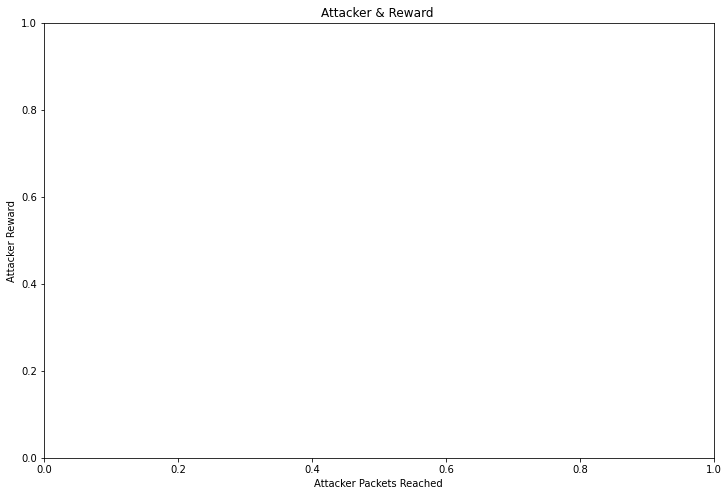

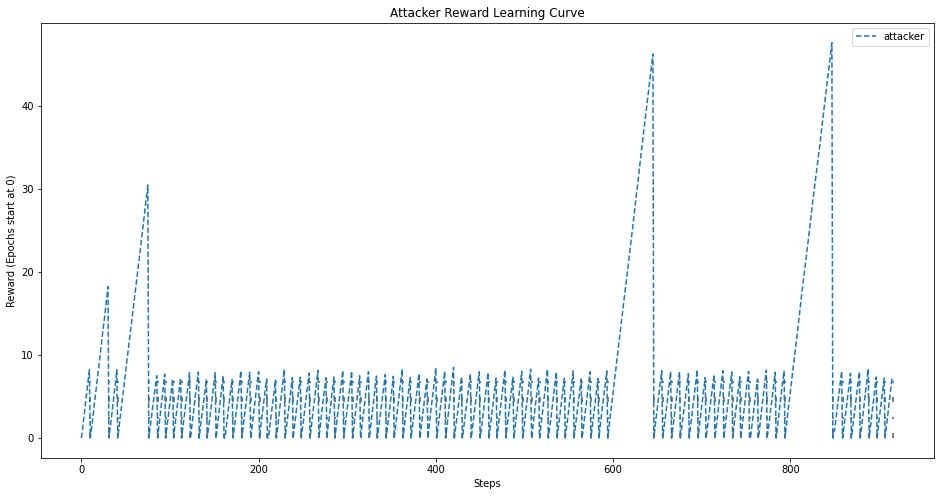

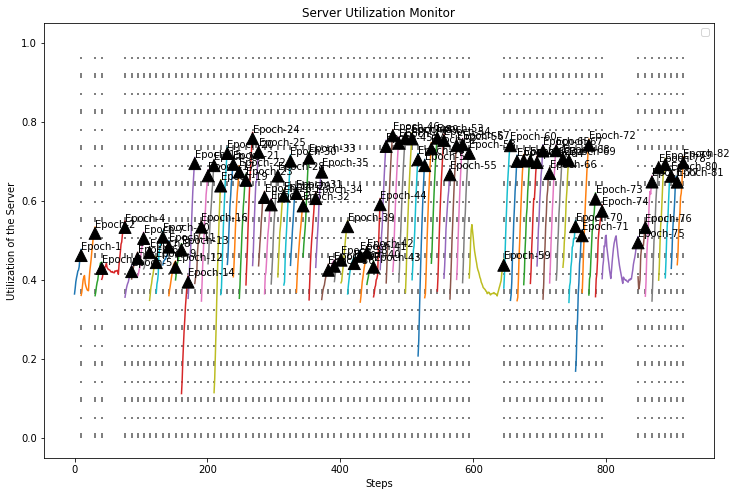

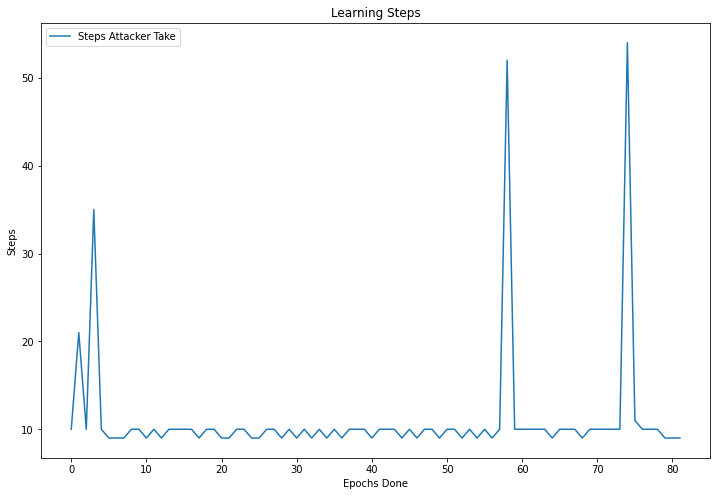

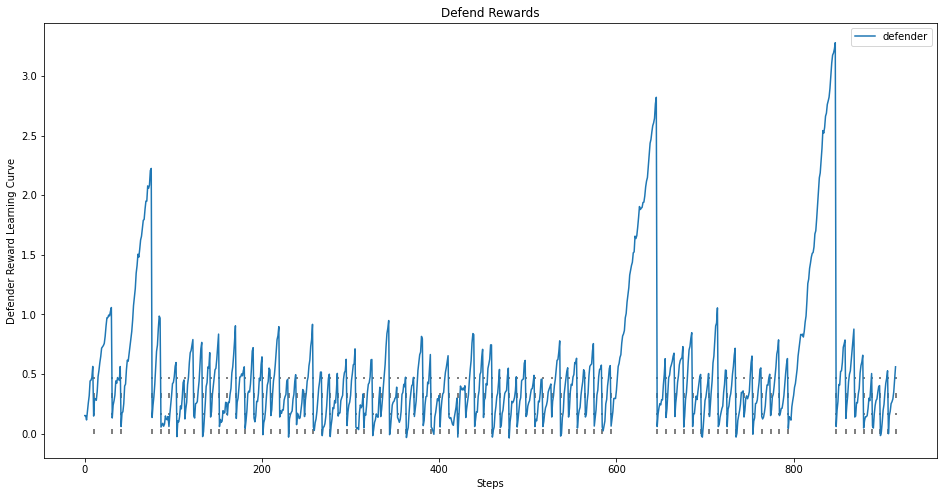

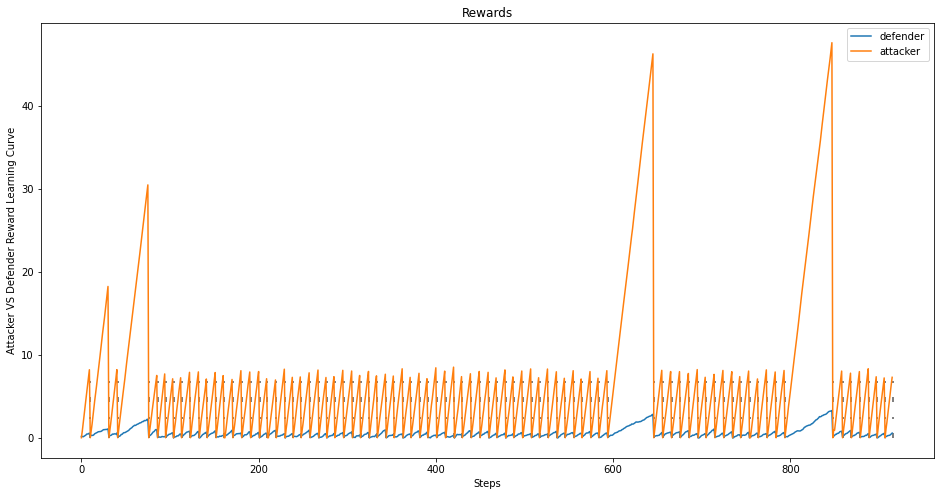

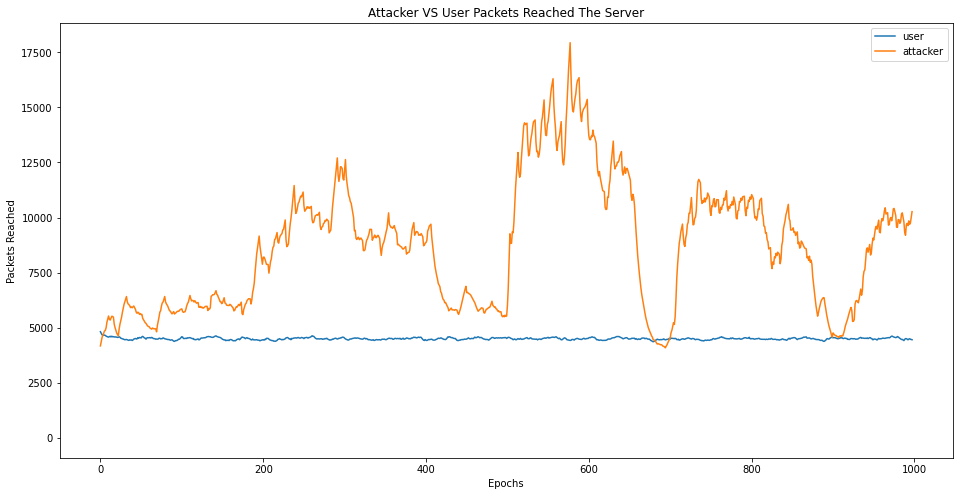

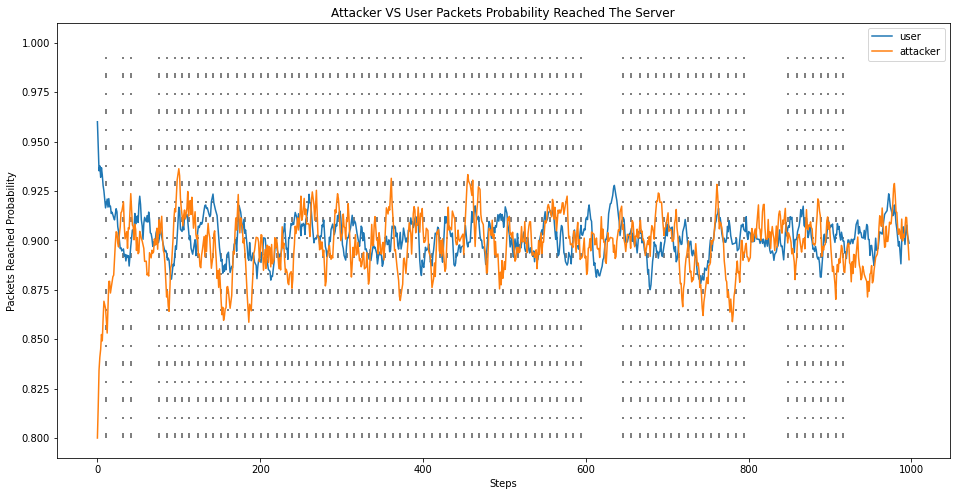

In [2]:
"""
from gym_cyberwargame.cbw_drawer.draw_with_logger import draw
train_args = get_args()
step_per_epoch = train_args.step_per_epoch
step_per_collect = train_args.step_per_collect
draw(cbw_logger, step_per_epoch, step_per_collect, save=True, name='Training')
"""
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
from scipy.interpolate import make_interp_spline


def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed
"""
attacker_reached = cbw_logger.attacker_reached
user_reached = cbw_logger.user_reached
attacker_rew = cbw_logger.attack_reward
util = cbw_logger.util
defend_reward = cbw_logger.defend_reward
user_reached_p = cbw_logger.user_reached_p
attacker_reached_p = cbw_logger.attack_reached_p
a_done = cbw_logger.a_done
d_done = cbw_logger.d_done

"""


def draw(logger, step_per_epoch, step_per_collect, save=False, name=''):
    attacker_reached = logger.attacker_reached
    user_reached = logger.user_reached
    attacker_rew = logger.attack_reward
    util = logger.util
    defend_reward = logger.defend_reward

    a_done = logger.a_done
    d_done = logger.d_done

    # print(attacker_rew[1])
    rew_array_all = []
    rew_array_defend = []
    user_reached_all = []
    attacker_reached_all = []
    user_reached_p = []
    attacker_reached_p = []
    user_reached_p_all = []
    attacker_reached_p_all = []

    user_reached_p = logger.user_reached_p
    attacker_reached_p = logger.attack_reached_p

    a_max_rew = 0
    b_max_rew = 0
    user_max_reached = 0
    # 1. print reward graphs
    fig1, ax = plt.subplots(figsize=(12,8))
    # ax.plot(attacker_reached[::2], attacker_rew[::2], label='attacker')
    fig2, ax2 = plt.subplots(figsize=(16,8))
    fig3, ax3 = plt.subplots(figsize=(12,8))
    fig4, ax4 = plt.subplots(figsize=(12,8))
    fig5, ax5 = plt.subplots(figsize=(16,8))
    fig6, ax6 = plt.subplots(figsize=(16,8))
    fig7, ax7 = plt.subplots(figsize=(16,8))
    fig8, ax8 = plt.subplots(figsize=(16,8))

    for i in range(len(attacker_rew)):
        if i <= 0:
            continue
        a_max_rew = max(np.array(attacker_rew[i]))
        b_max_rew = max(np.array(defend_reward[i]))
        user_max_reached = max(np.array(user_reached[i]))

    step=0
    for i in range(len(attacker_rew)):
        if i <= 0:
            continue
        step += len(attacker_rew[i])
        for j in range(len(attacker_rew[i])):
            ax2.vlines(step, 0, a_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
            ax3.vlines(step, 0, 1, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
            ax5.vlines(step, 0, b_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
            ax6.vlines(step, 0, a_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='.5')
            ax7.vlines(step, 0, 1, linestyle=(0, (3, 10, 1, 10)), colors='.5')
            ax8.vlines(step, 0.8, 1, linestyle=(0, (3, 10, 1, 10)), colors='.5')
            # a_max_rew = max(attacker_rew[i][j], a_max_rew)
            rew_array_all.append(float(attacker_rew[i][j]))
            rew_array_defend.append(float(defend_reward[i][j]))

    print("a {}, b {}".format(a_max_rew, b_max_rew))
    # print(rew_array_defend)

    # 2. set title and axis
    ax.set_xlabel('Attacker Packets Reached')
    ax.set_ylabel('Attacker Reward')
    ax.set_title('Attacker & Reward ')

    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Reward (Epochs start at 0)')
    ax2.set_title('Attacker Reward Learning Curve')

    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Utilization of the Server')
    ax3.set_title('Server Utilization Monitor')

    ax4.set_xlabel('Epochs Done')
    ax4.set_ylabel('Steps')
    ax4.set_title('Learning Steps')

    ax5.set_xlabel('Steps')
    ax5.set_ylabel('Defender Reward Learning Curve')
    ax5.set_title('Defend Rewards')

    ax6.set_xlabel('Steps')
    ax6.set_ylabel('Attacker VS Defender Reward Learning Curve')
    ax6.set_title('Rewards')

    ax7.set_xlabel('Epochs')
    ax7.set_ylabel('Packets Reached')
    ax7.set_title('Attacker VS User Packets Reached The Server')

    ax8.set_xlabel('Steps')
    ax8.set_ylabel('Packets Reached Probability')
    ax8.set_title('Attacker VS User Packets Probability Reached The Server')


    step_take = []
    # 3. Draw the reward for each epochs
    for i in range(len(attacker_rew)):
        # ax.plot(attacker_reached[i], attacker_rew[i], label='attacker')
        # ax2.plot(attacker_rew[i], label='attacker')
        # Util smooth
        """
        if i>=len(attacker_rew)-5:
            util_x = np.array(range(len(util[i])))
            util_y = util[i]
            X_Y_Spline = make_interp_spline(util_x, util_y)
            X_ = np.linspace(util_x.min(), util_x.max(), 100)
            Y_ = X_Y_Spline(X_)
            ax3.plot(util_x, util_y)
        """

        if i>=1:
            util_x = np.array(range(len(util[i])))
            util_y = np.array(util[i])
            util_y_sm = smooth(util_y, 0.9)
            current_step = 0
            for i_step in step_take:
                current_step+=int(i_step)
            ax3.plot(current_step+util_x, util_y_sm)
            # if i % 10 == 0 or i == 1:
            ax3.annotate('Epoch-'+str(i), xy=(current_step+util_x[-1], util_y_sm[-1]),
                     xytext=(current_step+util_x[-1], util_y_sm[-1]), arrowprops=dict(facecolor='black', shrink=0.05))
            # ax3.plot(util_x, util_y)
            step_take.append(len(attacker_rew[i]))
            # print("Got len step with",len(attacker_reached[i]))
            for itemU in user_reached[i]:
                user_reached_all.append(float(itemU))
            for itemA in attacker_reached[i]:
                attacker_reached_all.append(float(itemA))
            for up in user_reached_p[i]:
                if up != 0.0:
                    user_reached_p_all.append(round(float(up), 2))
            for ap in attacker_reached_p[i]:
                if ap != 0.0:
                    attacker_reached_p_all.append(round(float(ap), 2))
            # user_reached_all.append(np.asarray(user_reached[i], dtype=float))
            # attacker_reached_all.append(np.asarray(attacker_reached[i], dtype=float))

    # ax.plot(attacker_reached, attacker_rew, label='defender')
    # ax.plot(user_reached, defend_reward, label='defender')
    # 2. print utilization graph
    ax2.plot(rew_array_all, linestyle='--', label='attacker')
    # ax2.plot([0]*len(rew_array_all), label='bottom')
    # ax3.plot([0.4]*max(len(i) for i in attacker_rew), linestyle='solid', label='threshold')
    print(step_take)
    ax4.plot(range(len(step_take)), step_take, label='Steps Attacker Take')
    ax5.plot(rew_array_defend, linestyle='-', label='defender')
    ax6.plot(rew_array_defend, linestyle='-', label='defender')
    ax6.plot(rew_array_all, label='attacker')
    ax7.plot(range(len(user_reached_all)), smooth(user_reached_all, 0.9), label='user')
    ax7.plot(range(len(attacker_reached_all)), smooth(attacker_reached_all, 0.9), label='attacker')

    ax8.plot(range(len(user_reached_p_all)), smooth(user_reached_p_all, 0.9), label='user')
    ax8.plot(range(len(attacker_reached_p_all)), smooth(attacker_reached_p_all, 0.9), label='attacker')


    # ax.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    ax6.legend()
    ax7.legend()
    ax8.legend()

    # Save Figure in file with format in Time-
    def save_train(step_per_epoch=step_per_epoch, step_per_collect=step_per_collect):
        # train_args = get_args()
        step_per_epoch = step_per_epoch
        step_per_collect = step_per_collect
        now_time = datetime.datetime.now()

        script_dir = os.path.dirname('train_results_RandomDefender/')
        results_dir = os.path.join(script_dir, now_time.strftime("%m-%d %H-%M")+'-epoch_step-' +\
                                   str(step_per_epoch) + ' collect_step-' + str(step_per_collect) \
                                   +'-'+name+'/')
        if not os.path.isdir(results_dir):
            os.makedirs(results_dir)

        fig1.savefig(os.path.join(results_dir, 'attacker_reward_Packets.png'))
        fig2.savefig(os.path.join(results_dir, 'attacker_reward.png'))
        fig3.savefig(os.path.join(results_dir, 'Server Utilization.png'))
        fig4.savefig(os.path.join(results_dir, 'Attacker Learning_step.png'))
        fig5.savefig(os.path.join(results_dir, 'defender_reward.png'))
        fig6.savefig(os.path.join(results_dir, 'Defender VS Attacker.png'))
        fig7.savefig(os.path.join(results_dir, 'Attacker & User Reached.png'))
        fig8.savefig(os.path.join(results_dir, 'Attacker & User Reached In Prob.png'))

    print("Attacker wins {}, And defender wins {}".format(a_done[-1], d_done[-1]))
    plt.show()
    if save:
        save_train()


train_args = get_args()
step_per_epoch = train_args.step_per_epoch
step_per_collect = train_args.step_per_collect
draw(cbw_logger, step_per_epoch, step_per_collect, save=False, name='Training')

### 1.2.2 For Eval

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


a [6.87128712], b [0.87194957]
[10, 10, 10, 10, 12, 22, 9, 9]
Attacker wins [7], And defender wins [0]


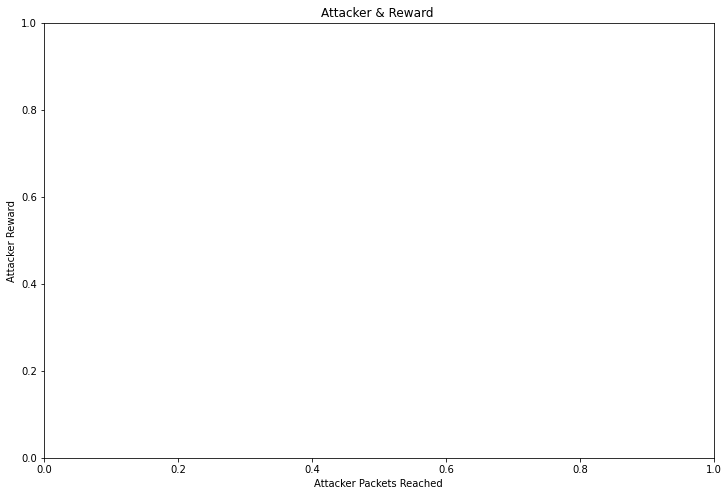

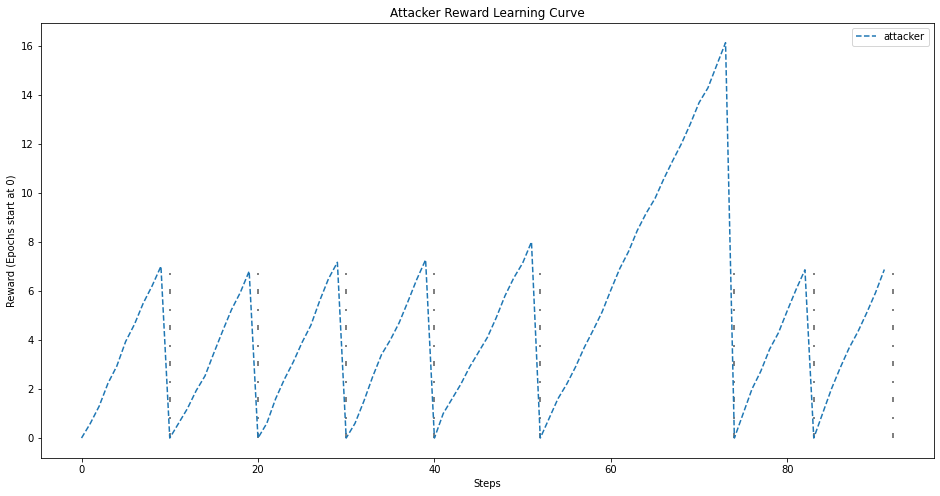

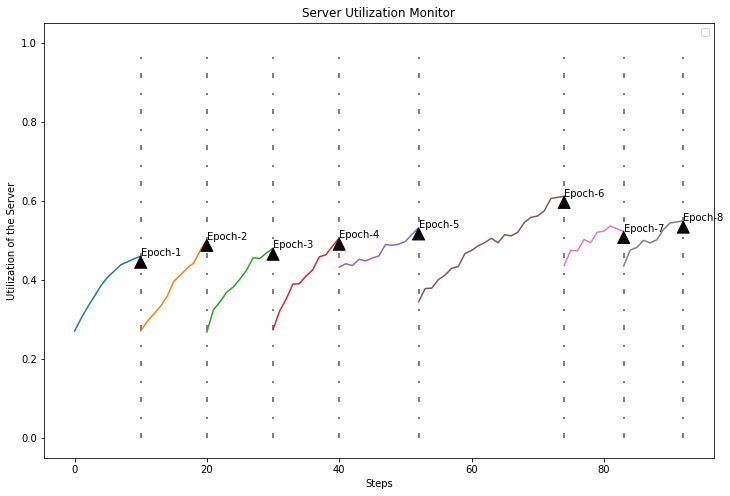

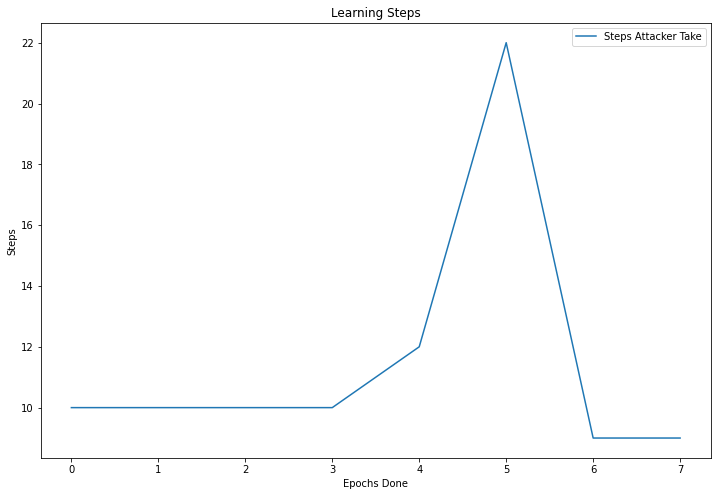

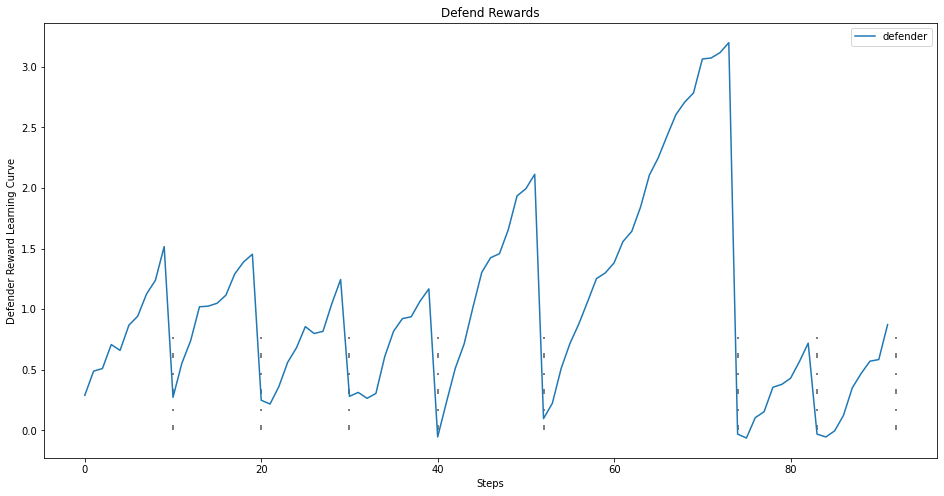

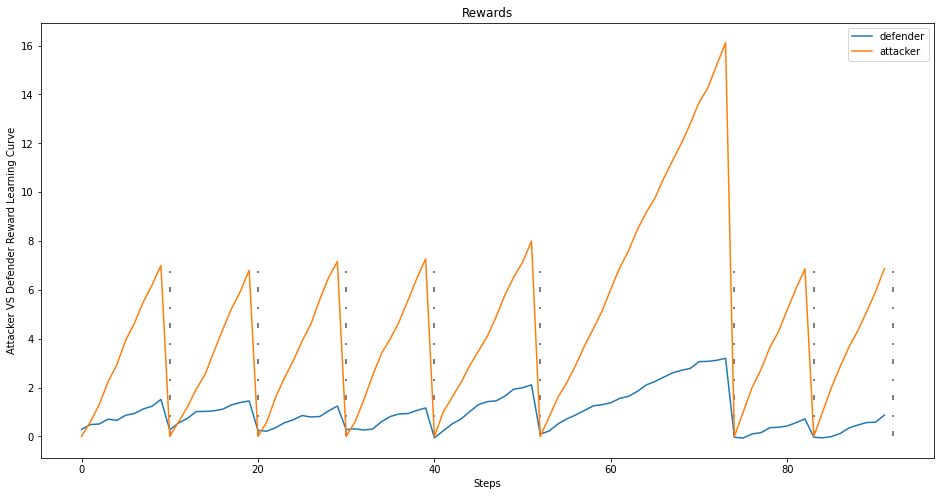

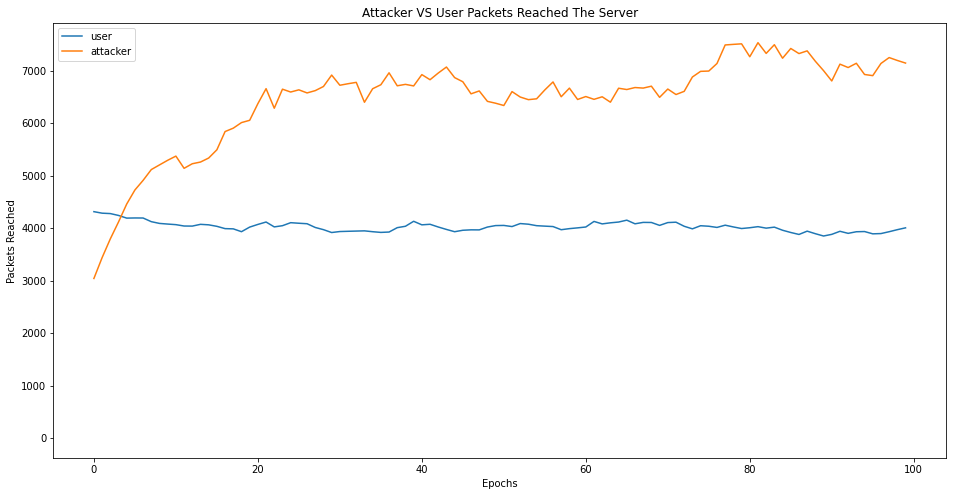

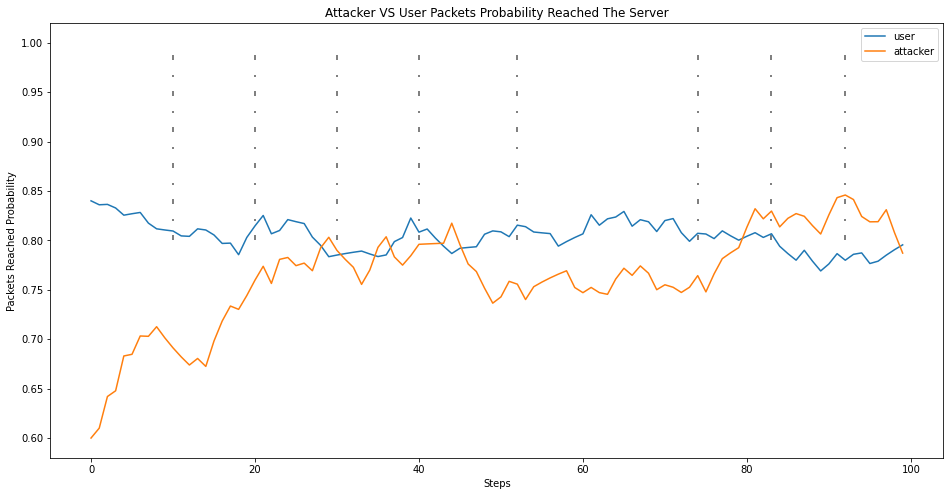

In [4]:
"""
from gym_cyberwargame.cbw_drawer.draw_with_logger import draw
train_args = get_args()
step_per_epoch = train_args.step_per_epoch
step_per_collect = train_args.step_per_collect
draw(cbw_logger, step_per_epoch, step_per_collect, save=True, name='Training')
"""
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
from scipy.interpolate import make_interp_spline


def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed
"""
attacker_reached = cbw_logger.attacker_reached
user_reached = cbw_logger.user_reached
attacker_rew = cbw_logger.attack_reward
util = cbw_logger.util
defend_reward = cbw_logger.defend_reward
user_reached_p = cbw_logger.user_reached_p
attacker_reached_p = cbw_logger.attack_reached_p
a_done = cbw_logger.a_done
d_done = cbw_logger.d_done

"""


def draw(logger, step_per_epoch, step_per_collect, save=False, name=''):
    attacker_reached = logger.attacker_reached
    user_reached = logger.user_reached
    attacker_rew = logger.attack_reward
    util = logger.util
    defend_reward = logger.defend_reward

    a_done = logger.a_done
    d_done = logger.d_done

    # print(attacker_rew[1])
    rew_array_all = []
    rew_array_defend = []
    user_reached_all = []
    attacker_reached_all = []
    user_reached_p = []
    attacker_reached_p = []
    user_reached_p_all = []
    attacker_reached_p_all = []

    user_reached_p = logger.user_reached_p
    attacker_reached_p = logger.attack_reached_p

    a_max_rew = 0
    b_max_rew = 0
    user_max_reached = 0
    # 1. print reward graphs
    fig1, ax = plt.subplots(figsize=(12,8))
    # ax.plot(attacker_reached[::2], attacker_rew[::2], label='attacker')
    fig2, ax2 = plt.subplots(figsize=(16,8))
    fig3, ax3 = plt.subplots(figsize=(12,8))
    fig4, ax4 = plt.subplots(figsize=(12,8))
    fig5, ax5 = plt.subplots(figsize=(16,8))
    fig6, ax6 = plt.subplots(figsize=(16,8))
    fig7, ax7 = plt.subplots(figsize=(16,8))
    fig8, ax8 = plt.subplots(figsize=(16,8))

    for i in range(len(attacker_rew)):
        if i <= 0:
            continue
        a_max_rew = max(np.array(attacker_rew[i]))
        b_max_rew = max(np.array(defend_reward[i]))
        user_max_reached = max(np.array(user_reached[i]))

    step=0
    for i in range(len(attacker_rew)):
        if i <= 0:
            continue
        step += len(attacker_rew[i])
        for j in range(len(attacker_rew[i])):
            ax2.vlines(step, 0, a_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
            ax3.vlines(step, 0, 1, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
            ax5.vlines(step, 0, b_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
            ax6.vlines(step, 0, a_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='.5')
            ax7.vlines(step, 0, 1, linestyle=(0, (3, 10, 1, 10)), colors='.5')
            ax8.vlines(step, 0.8, 1, linestyle=(0, (3, 10, 1, 10)), colors='.5')
            # a_max_rew = max(attacker_rew[i][j], a_max_rew)
            rew_array_all.append(float(attacker_rew[i][j]))
            rew_array_defend.append(float(defend_reward[i][j]))

    print("a {}, b {}".format(a_max_rew, b_max_rew))
    # print(rew_array_defend)

    # 2. set title and axis
    ax.set_xlabel('Attacker Packets Reached')
    ax.set_ylabel('Attacker Reward')
    ax.set_title('Attacker & Reward ')

    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Reward (Epochs start at 0)')
    ax2.set_title('Attacker Reward Learning Curve')

    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Utilization of the Server')
    ax3.set_title('Server Utilization Monitor')

    ax4.set_xlabel('Epochs Done')
    ax4.set_ylabel('Steps')
    ax4.set_title('Learning Steps')

    ax5.set_xlabel('Steps')
    ax5.set_ylabel('Defender Reward Learning Curve')
    ax5.set_title('Defend Rewards')

    ax6.set_xlabel('Steps')
    ax6.set_ylabel('Attacker VS Defender Reward Learning Curve')
    ax6.set_title('Rewards')

    ax7.set_xlabel('Epochs')
    ax7.set_ylabel('Packets Reached')
    ax7.set_title('Attacker VS User Packets Reached The Server')

    ax8.set_xlabel('Steps')
    ax8.set_ylabel('Packets Reached Probability')
    ax8.set_title('Attacker VS User Packets Probability Reached The Server')


    step_take = []
    # 3. Draw the reward for each epochs
    for i in range(len(attacker_rew)):
        # ax.plot(attacker_reached[i], attacker_rew[i], label='attacker')
        # ax2.plot(attacker_rew[i], label='attacker')
        # Util smooth
        """
        if i>=len(attacker_rew)-5:
            util_x = np.array(range(len(util[i])))
            util_y = util[i]
            X_Y_Spline = make_interp_spline(util_x, util_y)
            X_ = np.linspace(util_x.min(), util_x.max(), 100)
            Y_ = X_Y_Spline(X_)
            ax3.plot(util_x, util_y)
        """

        if i>=1:
            util_x = np.array(range(len(util[i])))
            util_y = np.array(util[i])
            util_y_sm = smooth(util_y, 0.9)
            current_step = 0
            for i_step in step_take:
                current_step+=int(i_step)
            ax3.plot(current_step+util_x, util_y_sm)
            # if i % 10 == 0 or i == 1:
            ax3.annotate('Epoch-'+str(i), xy=(current_step+util_x[-1], util_y_sm[-1]),
                     xytext=(current_step+util_x[-1], util_y_sm[-1]), arrowprops=dict(facecolor='black', shrink=0.05))
            # ax3.plot(util_x, util_y)
            step_take.append(len(attacker_rew[i]))
            # print("Got len step with",len(attacker_reached[i]))
            for itemU in user_reached[i]:
                user_reached_all.append(float(itemU))
            for itemA in attacker_reached[i]:
                attacker_reached_all.append(float(itemA))
            for up in user_reached_p[i]:
                if up != 0.0:
                    user_reached_p_all.append(round(float(up), 2))
            for ap in attacker_reached_p[i]:
                if ap != 0.0:
                    attacker_reached_p_all.append(round(float(ap), 2))
            # user_reached_all.append(np.asarray(user_reached[i], dtype=float))
            # attacker_reached_all.append(np.asarray(attacker_reached[i], dtype=float))

    # ax.plot(attacker_reached, attacker_rew, label='defender')
    # ax.plot(user_reached, defend_reward, label='defender')
    # 2. print utilization graph
    ax2.plot(rew_array_all, linestyle='--', label='attacker')
    # ax2.plot([0]*len(rew_array_all), label='bottom')
    # ax3.plot([0.4]*max(len(i) for i in attacker_rew), linestyle='solid', label='threshold')
    print(step_take)
    ax4.plot(range(len(step_take)), step_take, label='Steps Attacker Take')
    ax5.plot(rew_array_defend, linestyle='-', label='defender')
    ax6.plot(rew_array_defend, linestyle='-', label='defender')
    ax6.plot(rew_array_all, label='attacker')
    ax7.plot(range(len(user_reached_all)), smooth(user_reached_all, 0.9), label='user')
    ax7.plot(range(len(attacker_reached_all)), smooth(attacker_reached_all, 0.9), label='attacker')

    ax8.plot(range(len(user_reached_p_all)), smooth(user_reached_p_all, 0.9), label='user')
    ax8.plot(range(len(attacker_reached_p_all)), smooth(attacker_reached_p_all, 0.9), label='attacker')


    # ax.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    ax6.legend()
    ax7.legend()
    ax8.legend()

    # Save Figure in file with format in Time-
    def save_train(step_per_epoch=step_per_epoch, step_per_collect=step_per_collect):
        # train_args = get_args()
        step_per_epoch = step_per_epoch
        step_per_collect = step_per_collect
        now_time = datetime.datetime.now()

        script_dir = os.path.dirname('train_results_RandomDefender/')
        results_dir = os.path.join(script_dir, now_time.strftime("%m-%d %H-%M")+'-epoch_step-' +\
                                   str(step_per_epoch) + ' collect_step-' + str(step_per_collect) \
                                   +'-'+name+'/')
        if not os.path.isdir(results_dir):
            os.makedirs(results_dir)

        fig1.savefig(os.path.join(results_dir, 'attacker_reward_Packets.png'))
        fig2.savefig(os.path.join(results_dir, 'attacker_reward.png'))
        fig3.savefig(os.path.join(results_dir, 'Server Utilization.png'))
        fig4.savefig(os.path.join(results_dir, 'Attacker Learning_step.png'))
        fig5.savefig(os.path.join(results_dir, 'defender_reward.png'))
        fig6.savefig(os.path.join(results_dir, 'Defender VS Attacker.png'))
        fig7.savefig(os.path.join(results_dir, 'Attacker & User Reached.png'))
        fig8.savefig(os.path.join(results_dir, 'Attacker & User Reached In Prob.png'))

    print("Attacker wins {}, And defender wins {}".format(a_done[-1], d_done[-1]))
    plt.show()
    if save:
        save_train()


train_args = get_args()
step_per_epoch = train_args.step_per_epoch
step_per_collect = train_args.step_per_collect
draw(cbw_logger_eval, step_per_epoch, step_per_collect, save=True
     , name='Eval')


## 2. Two Agent Game With BranchDQN
1. Defender Pattern: action is a branch reprents the dropping volume for each ip_src host
2.

In [1]:
import argparse
import os
from copy import deepcopy
from typing import Optional, Tuple

import gym
import numpy as np
import torch
from pettingzoo.classic import tictactoe_v3
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, VectorReplayBuffer, Batch
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import (
    BasePolicy,
    DQNPolicy,
    MultiAgentPolicyManager,
    RandomPolicy,
    BranchingDQNPolicy
)
from tianshou.trainer import offpolicy_trainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net, BranchingNet
from supersuit import pad_observations_v0, pad_action_space_v0
from gym_cyberwargame.envs.cyberwargame_env_multiagent import env


def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=1626)
    parser.add_argument('--eps-test', type=float, default=0.05)
    parser.add_argument('--eps-train', type=float, default=0.15)
    parser.add_argument('--buffer-size', type=int, default=20000)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument(
        '--gamma', type=float, default=0.9, help='a smaller gamma favors earlier win'
    )
    parser.add_argument('--n-step', type=int, default=2)                # used in DQNPolicy(), estimation_step, number of step to look ahead; less for less loss
    parser.add_argument('--target-update-freq', type=int, default=0)  # the target network update frequency
    parser.add_argument('--epoch', type=int, default=1)
    parser.add_argument('--step-per-epoch', type=int, default=2000)
    # trainer will collect “step_per_collect” transitions and do policy network update repeatedly in each epoch.
    # 实际调用是collector的collect中的n_step
    parser.add_argument('--step-per-collect', type=int, default=200)
    # Used for BranchDQNPolicy()
    parser.add_argument("--action-per-branch", type=int, default=5)
    parser.add_argument("--num-branches", type=int, default=15)
    parser.add_argument("--common-hidden-sizes", type=int, nargs="*", default=[128, 128, 128, 128, 128])
    parser.add_argument("--action-hidden-sizes", type=int, nargs="*", default=[128, 128, 128, 128, 128])
    parser.add_argument("--value-hidden-sizes", type=int, nargs="*", default=[128, 128, 128, 128, 128])

    parser.add_argument('--update-per-step', type=float, default=2)
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument(
        '--hidden-sizes', type=int, nargs='*', default=[128, 128, 128, 128]
    )
    parser.add_argument('--training-num', type=int, default=1)
    parser.add_argument('--test-num', type=int, default=1)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.1)
    parser.add_argument(
        '--win-rate',
        type=float,
        default=0.6,
        help='the expected winning rate: Optimal policy can get 0.7'
    )
    parser.add_argument(
        '--watch',
        default=False,
        action='store_true',
        help='no training, '
        'watch the play of pre-trained models'
    )
    parser.add_argument(
        '--agent-id',
        type=int,
        default=2,
        help='the learned agent plays as the'
        ' agent_id-th player. Choices are 1 and 2.'
    )
    parser.add_argument(
        '--resume-path',
        type=str,
        default='',
        help='the path of agent pth file '
        'for resuming from a pre-trained agent'
    )
    parser.add_argument(
        '--opponent-path',
        type=str,
        default='',
        help='the path of opponent agent pth file '
        'for resuming from a pre-trained agent'
    )
    parser.add_argument(
        '--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu'
    )
    return parser


def get_args() -> argparse.Namespace:
    parser = get_parser()
    return parser.parse_known_args()[0]


def get_env():
    cbw_env_pz = env()
    cbw_env_pz = pad_observations_v0(cbw_env_pz)
    cbw_env_pz = pad_action_space_v0(cbw_env_pz)
    cbw_ts = PettingZooEnv(cbw_env_pz)
    return cbw_ts

def get_agents(
    args: argparse.Namespace = get_args(),
    agent_attacker: Optional[BasePolicy] = None,
    agent_defender: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    if_agent_attacker_random = False,
    if_agent_defender_random = False
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = get_env()
    observation_space = env.observation_space['observation'] if isinstance(
        env.observation_space, gym.spaces.Dict
    ) else env.observation_space
    args.state_shape = observation_space.shape or observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n

    print("get state_shape {}, action_shape {}".format(args.state_shape, args.action_shape))
    args.num_branches = 15

    a_net = BranchingNet(
        state_shape= args.state_shape,
        num_branches=args.num_branches,
        action_per_branch=25, # args.action_per_branch,
        common_hidden_sizes=args.common_hidden_sizes,
        value_hidden_sizes=args.value_hidden_sizes,
        action_hidden_sizes=args.action_hidden_sizes,
        device=args.device,
    ).to(args.device)
    a_optim = torch.optim.Adam(a_net.parameters(), lr=args.lr)
    agent_attacker = BranchingDQNPolicy(
        a_net, a_optim, discount_factor=0.8, target_update_freq=args.target_update_freq
    )
    print("Running Device  {} {}".format(args.device, torch.cuda.is_available()))

    # model
    d_net = BranchingNet(
        args.state_shape,
        args.num_branches,
        args.action_per_branch,    # 5
        args.common_hidden_sizes,
        args.value_hidden_sizes,
        args.action_hidden_sizes,
        device=args.device,
    ).to(args.device)
    d_optim = torch.optim.Adam(d_net.parameters(), lr=args.lr)
    agent_defender = BranchingDQNPolicy(
        d_net, d_optim, args.gamma, target_update_freq=args.target_update_freq
    )
    """
    # Test for Defender as DQNPolicy()
    agent_defender = DQNPolicy(
        net,
        optim,
        args.gamma,
        args.n_step,
        target_update_freq=args.target_update_freq
    )
    """
    # agent_defender = RandomPolicy()
    # 0-attacker, 1-defender
    # if if_agent_attacker_random:
    #     agent_attacker = RandomPolicy()
    # elif if_agent_defender_random:
    #     agent_defender = RandomPolicy()

    agents = [agent_attacker, agent_defender]
    print("Getting Agents {}".format(agents[0]))
    policy = MultiAgentPolicyManager(agents, env)
    return policy, optim, env.agents

# Logger Class to record
class CBW_Logger:

    def __init__(self, writer):
        self.cnt = 0
        self.writer = writer
        self.user_reached_step = []
        self.attacker_reached_step = []
        self.attack_reward_step = []
        self.defend_reward_step = []
        self.attack_reached_p_step = []
        self.user_reached_p_step = []
        self.util_step = []

        self.user_reached = []
        self.attacker_reached = []
        self.attack_reached_p = []
        self.user_reached_p = []
        self.attack_reward = []
        self.defend_reward = []
        self.util = []
        # Track win epochs
        self.a_done = []
        self.d_done = []
    def preprocess_fn(self, **kwargs):
        # modify info before adding into the buffer, and recorded into tfb
        # if obs && env_id exist -> reset
        # if obs_next/rew/done/info/env_id exist -> normal step
        if 'rew' in kwargs:
            # print(kwargs)
            info = kwargs['info']
            # print(info)
            # print("!!!!! in preprocess, get info {}".format(info))
            for key in info.keys():
                if key == 'user_reached' or key == 'attacker_reached' or key == 'attack_reward' or key=='util'\
                        or key == 'defend_reward' or key =='a_done' or key=='d_done'\
                        or key == 'attacker_reached_p' or key == 'user_reached_p' or key=='agent':
                    self.a_done.append(info.a_done)
                    self.d_done.append(info.d_done)
                    if info.agent == 'attacker':
                    # if self.cnt%2==0:
                        self.attack_reward_step.append(info.attack_reward)
                    elif info.agent == 'defender':
                        self.attacker_reached_step.append(info.attacker_reached)
                        self.user_reached_step.append(info.user_reached)
                        self.defend_reward_step.append(info.defend_reward)
                        self.util_step.append(info.util)
                        self.attack_reached_p_step.append(info.attacker_reached_p)
                        self.user_reached_p_step.append(info.user_reached_p)
                    break
            self.cnt += 1
            # print("Self.attacker_reached {} {}".format(self.user_reached,self.attacker_reached ))
            # print("Type of obs now is {}".format(type(obs)))
            # print("In rew, Batch(obs=obs, info=info) {}".format(Batch(obs_next=[obs_next], rew=[rew], info=[info], done=[done])))
            return Batch(info=info)
        else:
            # Call at reset()
            self.cnt = 0
            self.user_reached.append(self.user_reached_step)
            self.attacker_reached.append(self.attacker_reached_step)
            self.attack_reward.append(self.attack_reward_step)
            self.util.append(self.util_step)
            self.defend_reward.append(self.defend_reward_step)
            self.attack_reached_p.append(self.attack_reached_p_step)
            self.user_reached_p.append(self.user_reached_p_step)

            self.user_reached_step = []
            self.defend_reward_step = []
            self.attacker_reached_step = []
            self.attack_reward_step = []
            self.attack_reached_p_step = []
            self.user_reached_p_step = []
            self.util_step = []
            # pass
            # print(kwargs)
            return Batch()

    @staticmethod
    def single_preprocess_fn(**kwargs):
        # same as above, without tfb
        if 'rew' in kwargs:
            info = kwargs['info']
            info.rew = kwargs['rew']
            return Batch(info=info)
        else:
            return Batch()

def get_logger():
    # ======== tensorboard logging setup =========
    log_path = os.path.join(args.logdir, 'cbw_tianshou_pettingzoo', 'dqn')
    # print("log_path {}".format(log_path))
    writer = SummaryWriter(log_path)
    writer.add_text("args", str(args))
    logger = TensorboardLogger(writer)
    cbw_logger = CBW_Logger(writer)

    return logger, cbw_logger


def train_agent(
    args: argparse.Namespace = get_args(),
    agent_attacker: Optional[BasePolicy] = None,
    agent_defender: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    logger=None,
    cbw_logger=None
) -> Tuple[dict, BasePolicy, BasePolicy]:

    # ======== environment setup =========
    train_envs = DummyVectorEnv([get_env for _ in range(args.training_num)])
    test_envs = DummyVectorEnv([get_env for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)

    # ======== agent setup =========
    policy, optim, agents = get_agents(
        args, agent_attacker=agent_attacker, agent_defender=agent_defender, optim=optim,
        if_agent_attacker_random=False, if_agent_defender_random=False
    )

    # ======== collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(args.buffer_size, len(train_envs)),
        exploration_noise=True,
        preprocess_fn=cbw_logger.preprocess_fn
    )

    test_collector = Collector(policy, test_envs, exploration_noise=True)
    test_collector = None
    # policy.set_eps(1)
    # train_collector.collect(n_step=args.batch_size * args.training_num)

    # ======== callback functions used during training =========
    def save_best_fn(policy):
        if hasattr(args, 'model_save_path'):
            model_save_path = args.model_save_path
        else:
            model_save_path = os.path.join(
                args.logdir, 'tic_tac_toe', 'dqn', 'policy.pth'
            )
        torch.save(
            policy.policies[agents[args.agent_id - 2]].state_dict(), model_save_path
        )

    def stop_fn(mean_rewards):
        return mean_rewards >= args.win_rate

    def train_fn(epoch, env_step):
        # print("Policy {}, and agent id {}".format(policy.policies, args.agent_id))
        policy.policies[agents[args.agent_id-2]].set_eps(args.eps_train)

    def test_fn(epoch, env_step):
        policy.policies[agents[args.agent_id - 2]].set_eps(args.eps_test)


    """
    f(rewards: np.ndarray with shape (num_episode, agent_num)) -> np.ndarray
        with shape (num_episode,)
    Use the scalar reward value during training
    """
    def reward_metric(rews):
        # print("Getting rews {}".format(rews))
        return rews[:, args.agent_id - 2]
    # ======== trainer =========
    # Use self-defined train process

    result = offpolicy_trainer(
        policy,                 # Policy contains two policies for attacker and defender
        train_collector,
        test_collector,
        args.epoch,             # Max epoch
        args.step_per_epoch,    # the number of transitions collected per epoch.
        args.step_per_collect,  #  trainer will collect “step_per_collect” transitions and do some policy network update repeatedly in each epoch.
        args.test_num,
        args.batch_size,
        train_fn=train_fn,
        test_fn=test_fn,
        # stop_fn=stop_fn,
        # save_best_fn=save_best_fn,
        update_per_step=args.update_per_step,
        logger=logger,
        test_in_train=False,
        reward_metric=reward_metric,
    )

    return result, policy

args = get_args()
logger, cbw_logger = get_logger()
result_multi, policy = train_agent(args, logger=logger, cbw_logger=cbw_logger)

F:\Anaconda3\envs\rl_env\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_ut

get state_shape (15, 3), action_shape (15,)
Running Device  cuda True
Getting Agents BranchingDQNPolicy(
  (model): BranchingNet(
    (common): MLP(
      (model): Sequential(
        (0): Linear(in_features=45, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, out_features=128, bias=True)
        (9): ReLU()
      )
    )
    (value): MLP(
      (model): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7):

Epoch #1: 2001it [26:29,  1.26it/s, attacker/loss=717064219998969266176.000, defender/loss=592.829, env_step=2000, len=324, n/ep=1, n/st=200, rew=13676.40]                          


 ##  Draw Reward Graphs for two agent

a_max_rew [83.37958878], b_max_rew [64.02085822]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[32, 58, 18, 35, 19, 82, 49, 20, 71, 49, 22, 14, 29, 56, 146, 49, 161]
Attacker wins [array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), ar

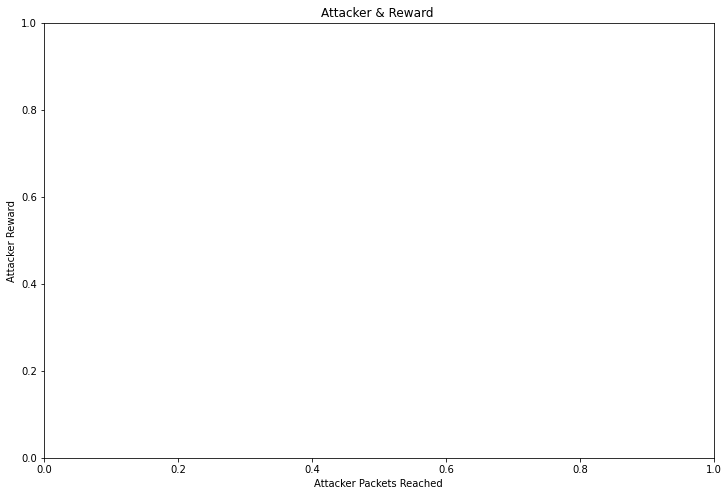

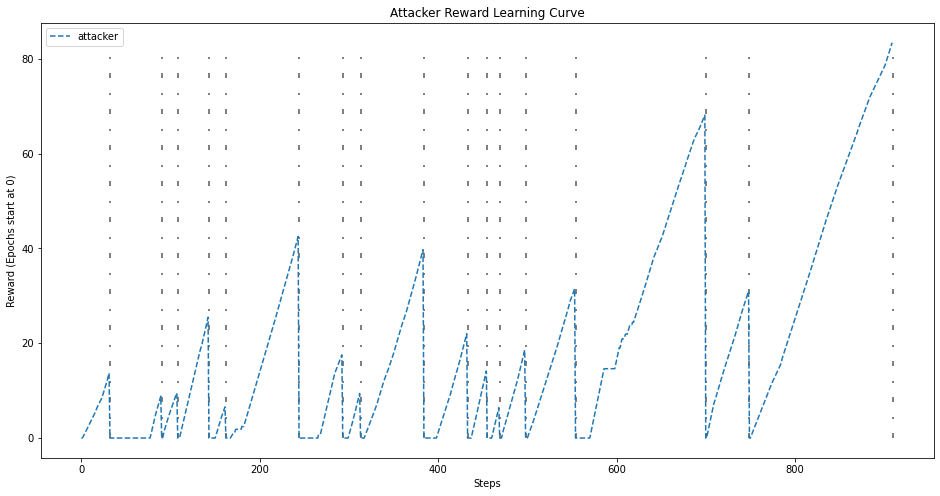

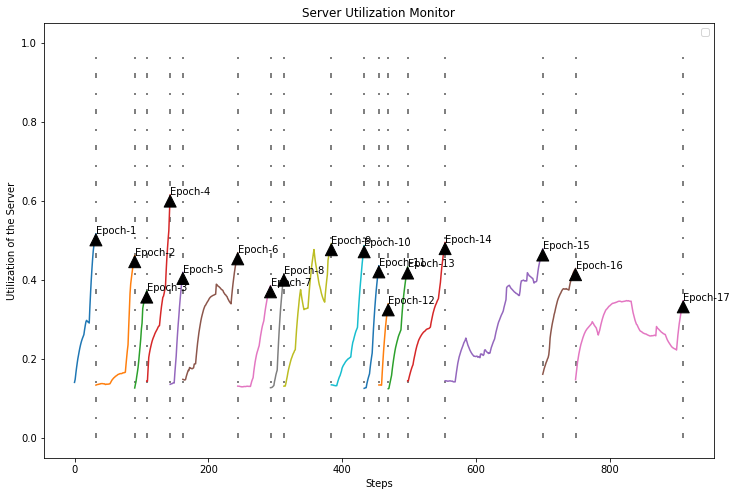

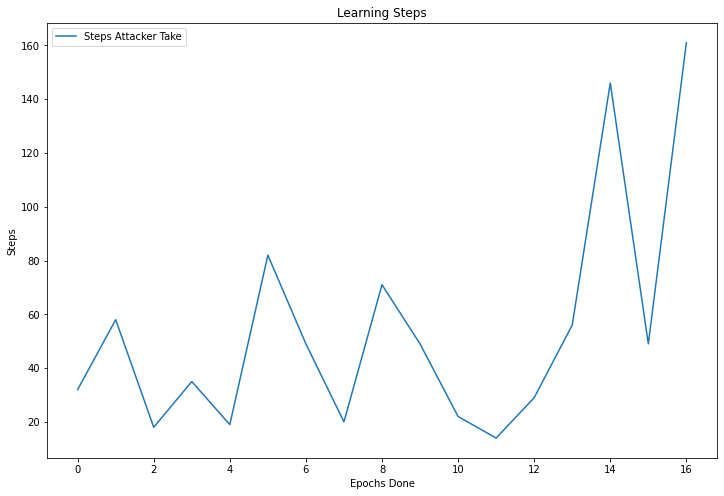

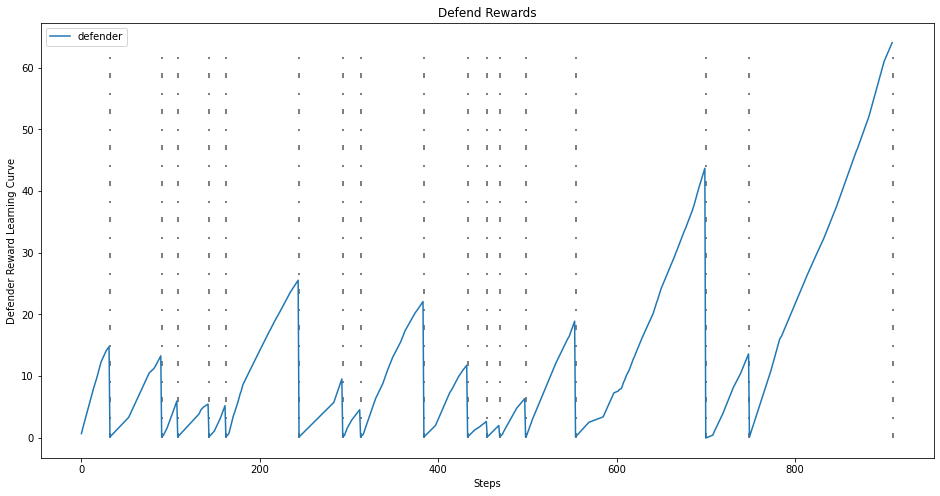

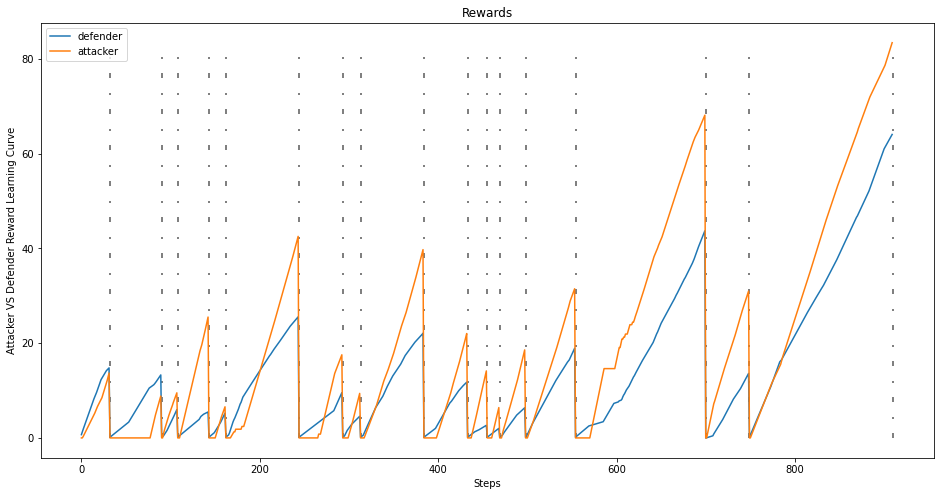

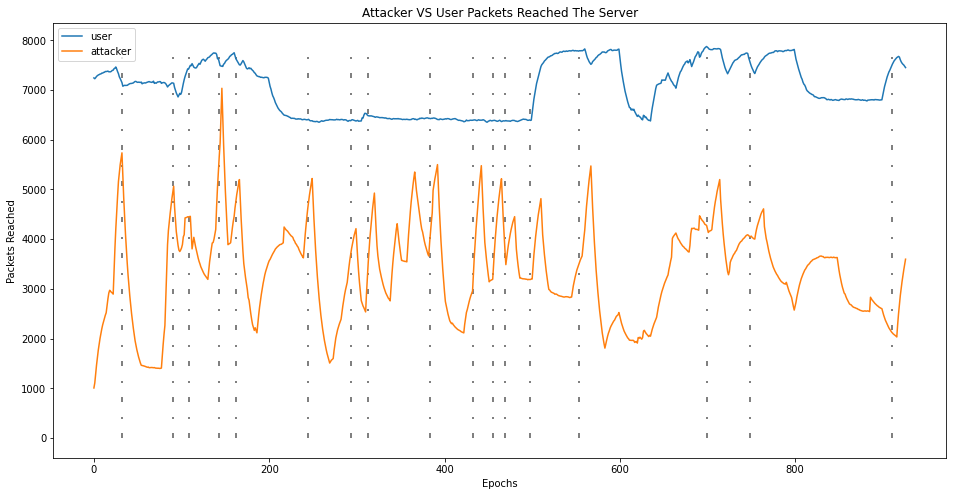

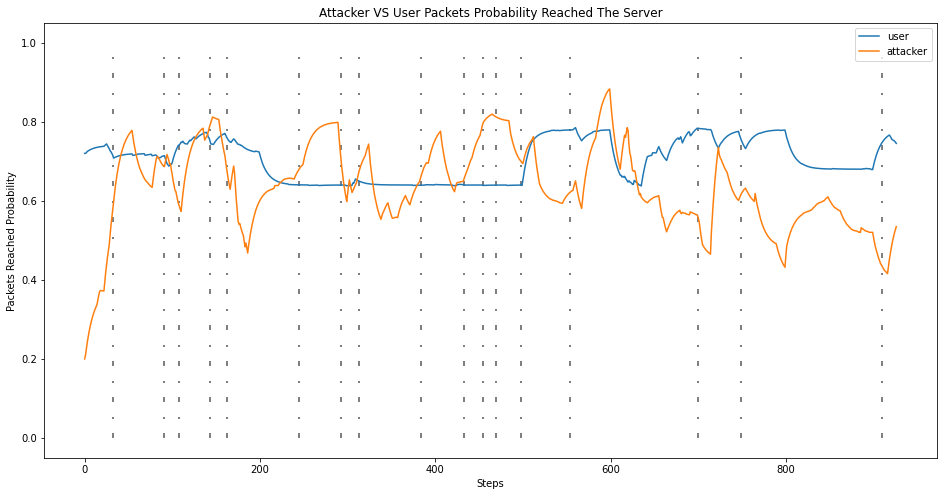

In [2]:
"""
from gym_cyberwargame.cbw_drawer.draw_with_logger import draw
train_args = get_args()
step_per_epoch = train_args.step_per_epoch
step_per_collect = train_args.step_per_collect
draw(cbw_logger, step_per_epoch, step_per_collect, save=True, name='Training')
"""
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
from scipy.interpolate import make_interp_spline


def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed
"""
attacker_reached = cbw_logger.attacker_reached
user_reached = cbw_logger.user_reached
attacker_rew = cbw_logger.attack_reward
util = cbw_logger.util
defend_reward = cbw_logger.defend_reward
user_reached_p = cbw_logger.user_reached_p
attacker_reached_p = cbw_logger.attack_reached_p
a_done = cbw_logger.a_done
d_done = cbw_logger.d_done

"""


def draw(logger, step_per_epoch, step_per_collect, save=False, name=''):
    attacker_reached = logger.attacker_reached
    user_reached = logger.user_reached
    attacker_rew = logger.attack_reward
    util = logger.util
    defend_reward = logger.defend_reward

    a_done = logger.a_done
    d_done = logger.d_done

    # print(attacker_rew[1])
    rew_array_all = []
    rew_array_defend = []
    user_reached_all = []
    attacker_reached_all = []
    user_reached_p = []
    attacker_reached_p = []
    user_reached_p_all = []
    attacker_reached_p_all = []

    user_reached_p = logger.user_reached_p
    attacker_reached_p = logger.attack_reached_p

    a_max_rew = 0
    b_max_rew = 0
    user_max_reached = 0
    max_reached=0
    max_rew=0
    # 1. print reward graphs
    fig1, ax = plt.subplots(figsize=(12,8))
    # ax.plot(attacker_reached[::2], attacker_rew[::2], label='attacker')
    fig2, ax2 = plt.subplots(figsize=(16,8))
    fig3, ax3 = plt.subplots(figsize=(12,8))
    fig4, ax4 = plt.subplots(figsize=(12,8))
    fig5, ax5 = plt.subplots(figsize=(16,8))
    fig6, ax6 = plt.subplots(figsize=(16,8))
    fig7, ax7 = plt.subplots(figsize=(16,8))
    fig8, ax8 = plt.subplots(figsize=(16,8))

    for i in range(len(attacker_rew)):
        if i <= 0:
            continue
        a_max_rew_tmp = max(np.array(attacker_rew[i]))
        a_max_rew = max(a_max_rew, a_max_rew_tmp)
        b_max_rew_tmp = max(np.array(defend_reward[i]))
        b_max_rew = max(b_max_rew, b_max_rew_tmp)
        max_rew = max([a_max_rew, b_max_rew])

        user_max_reached = max(np.array(user_reached[i]))
        a_max_reached = max(np.array(attacker_reached[i]))
        max_reached = max([a_max_reached, user_max_reached])
    print("a_max_rew {}, b_max_rew {}".format(a_max_rew, b_max_rew))
    step=0
    for i in range(len(attacker_rew)):
        if i <= 0:
            continue
        step += len(attacker_rew[i])
        for j in range(len(attacker_rew[i])):
            ax2.vlines(step, 0, a_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
            ax3.vlines(step, 0, 1, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
            ax5.vlines(step, 0, b_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
            ax6.vlines(step, 0, max_rew, linestyle=(0, (3, 10, 1, 10)), colors='.5')
            ax7.vlines(step, 0, max_reached, linestyle=(0, (3, 10, 1, 10)), colors='.5')
            ax8.vlines(step, 0, 1, linestyle=(0, (3, 10, 1, 10)), colors='.5')
            # a_max_rew = max(attacker_rew[i][j], a_max_rew)
            rew_array_all.append(float(attacker_rew[i][j]))
            rew_array_defend.append(float(defend_reward[i][j]))

    # print("a {}, b {}".format(a_max_rew, b_max_rew))
    # print(rew_array_defend)

    # 2. set title and axis
    ax.set_xlabel('Attacker Packets Reached')
    ax.set_ylabel('Attacker Reward')
    ax.set_title('Attacker & Reward ')

    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Reward (Epochs start at 0)')
    ax2.set_title('Attacker Reward Learning Curve')

    ax3.set_xlabel('Steps')
    ax3.set_ylabel('Utilization of the Server')
    ax3.set_title('Server Utilization Monitor')

    ax4.set_xlabel('Epochs Done')
    ax4.set_ylabel('Steps')
    ax4.set_title('Learning Steps')

    ax5.set_xlabel('Steps')
    ax5.set_ylabel('Defender Reward Learning Curve')
    ax5.set_title('Defend Rewards')

    ax6.set_xlabel('Steps')
    ax6.set_ylabel('Attacker VS Defender Reward Learning Curve')
    ax6.set_title('Rewards')

    ax7.set_xlabel('Epochs')
    ax7.set_ylabel('Packets Reached')
    ax7.set_title('Attacker VS User Packets Reached The Server')

    ax8.set_xlabel('Steps')
    ax8.set_ylabel('Packets Reached Probability')
    ax8.set_title('Attacker VS User Packets Probability Reached The Server')


    step_take = []
    # 3. Draw the reward for each epochs
    for i in range(len(attacker_rew)):
        # ax.plot(attacker_reached[i], attacker_rew[i], label='attacker')
        # ax2.plot(attacker_rew[i], label='attacker')
        # Util smooth
        """
        if i>=len(attacker_rew)-5:
            util_x = np.array(range(len(util[i])))
            util_y = util[i]
            X_Y_Spline = make_interp_spline(util_x, util_y)
            X_ = np.linspace(util_x.min(), util_x.max(), 100)
            Y_ = X_Y_Spline(X_)
            ax3.plot(util_x, util_y)
        """

        if i>=1:
            util_x = np.array(range(len(util[i])))
            util_y = np.array(util[i])
            util_y_sm = smooth(util_y, 0.9)
            current_step = 0
            for i_step in step_take:
                current_step+=int(i_step)
            ax3.plot(current_step+util_x, util_y_sm)
            # if i % 10 == 0 or i == 1:
            ax3.annotate('Epoch-'+str(i), xy=(current_step+util_x[-1], util_y_sm[-1]),
                     xytext=(current_step+util_x[-1], util_y_sm[-1]), arrowprops=dict(facecolor='black', shrink=0.05))
            # ax3.plot(util_x, util_y)
            step_take.append(len(attacker_rew[i]))
            # print("Got len step with",len(attacker_reached[i]))
            for itemU in user_reached[i]:
                user_reached_all.append(float(itemU))
            for itemA in attacker_reached[i]:
                attacker_reached_all.append(float(itemA))
            for up in user_reached_p[i]:
                if up != 0.0:
                    user_reached_p_all.append(round(float(up), 2))
            for ap in attacker_reached_p[i]:
                if ap != 0.0:
                    attacker_reached_p_all.append(round(float(ap), 2))
            # user_reached_all.append(np.asarray(user_reached[i], dtype=float))
            # attacker_reached_all.append(np.asarray(attacker_reached[i], dtype=float))

    # ax.plot(attacker_reached, attacker_rew, label='defender')
    # ax.plot(user_reached, defend_reward, label='defender')
    # 2. print utilization graph
    ax2.plot(rew_array_all, linestyle='--', label='attacker')
    # ax2.plot([0]*len(rew_array_all), label='bottom')
    # ax3.plot([0.4]*max(len(i) for i in attacker_rew), linestyle='solid', label='threshold')
    print(step_take)
    ax4.plot(range(len(step_take)), step_take, label='Steps Attacker Take')
    ax5.plot(rew_array_defend, linestyle='-', label='defender')
    ax6.plot(rew_array_defend, linestyle='-', label='defender')
    ax6.plot(rew_array_all, label='attacker')
    ax7.plot(range(len(user_reached_all)), smooth(user_reached_all, 0.9), label='user')
    ax7.plot(range(len(attacker_reached_all)), smooth(attacker_reached_all, 0.9), label='attacker')

    ax8.plot(range(len(user_reached_p_all)), smooth(user_reached_p_all, 0.9), label='user')
    ax8.plot(range(len(attacker_reached_p_all)), smooth(attacker_reached_p_all, 0.9), label='attacker')


    # ax.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    ax5.legend()
    ax6.legend()
    ax7.legend()
    ax8.legend()

    # Save Figure in file with format in Time-
    def save_train(step_per_epoch=step_per_epoch, step_per_collect=step_per_collect):
        # train_args = get_args()
        step_per_epoch = step_per_epoch
        step_per_collect = step_per_collect
        now_time = datetime.datetime.now()

        script_dir = os.path.dirname('train_results/')
        results_dir = os.path.join(script_dir, now_time.strftime("%m-%d %H-%M")+'-epoch_step-' +\
                                   str(step_per_epoch) + ' collect_step-' + str(step_per_collect) \
                                   +'-'+name+'/')
        if not os.path.isdir(results_dir):
            os.makedirs(results_dir)

        fig1.savefig(os.path.join(results_dir, 'attacker_reward_Packets.png'))
        fig2.savefig(os.path.join(results_dir, 'attacker_reward.png'))
        fig3.savefig(os.path.join(results_dir, 'Server Utilization.png'))
        fig4.savefig(os.path.join(results_dir, 'Attacker Learning_step.png'))
        fig5.savefig(os.path.join(results_dir, 'defender_reward.png'))
        fig6.savefig(os.path.join(results_dir, 'Defender VS Attacker.png'))
        fig7.savefig(os.path.join(results_dir, 'Attacker & User Reached.png'))
        fig8.savefig(os.path.join(results_dir, 'Attacker & User Reached In Prob.png'))

    print("Attacker wins {}, And defender wins {}".format(a_done, d_done))
    plt.show()
    if save:
        save_train()


train_args = get_args()
step_per_epoch = train_args.step_per_epoch
step_per_collect = train_args.step_per_collect
draw(cbw_logger, step_per_epoch, step_per_collect, save=False, name='Training')

## 3. Random Attacker VS Defender

In [1]:
import argparse
import os
from copy import deepcopy
from typing import Optional, Tuple

import gym
import numpy as np
import torch
from pettingzoo.classic import tictactoe_v3
from torch.utils.tensorboard import SummaryWriter

from tianshou.data import Collector, VectorReplayBuffer, Batch
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import (
    BasePolicy,
    DQNPolicy,
    MultiAgentPolicyManager,
    RandomPolicy,
    BranchingDQNPolicy
)
from tianshou.trainer import offpolicy_trainer
from tianshou.utils import TensorboardLogger
from tianshou.utils.net.common import Net, BranchingNet
from supersuit import pad_observations_v0, pad_action_space_v0
from gym_cyberwargame.envs.cyberwargame_env_multiagent_attackerRandom import env


def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', type=int, default=1626)
    parser.add_argument('--eps-test', type=float, default=0.05)
    parser.add_argument('--eps-train', type=float, default=0.15)
    parser.add_argument('--buffer-size', type=int, default=20000)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument(
        '--gamma', type=float, default=0.9, help='a smaller gamma favors earlier win'
    )
    parser.add_argument('--n-step', type=int, default=2)                # used in DQNPolicy(), estimation_step, number of step to look ahead; less for less loss
    parser.add_argument('--target-update-freq', type=int, default=0)  # the target network update frequency
    parser.add_argument('--epoch', type=int, default=1)
    parser.add_argument('--step-per-epoch', type=int, default=2000)
    # trainer will collect “step_per_collect” transitions and do policy network update repeatedly in each epoch.
    # 实际调用是collector的collect中的n_step
    parser.add_argument('--step-per-collect', type=int, default=400)
    # Used for BranchDQNPolicy()
    parser.add_argument("--action-per-branch", type=int, default=5)
    parser.add_argument("--num-branches", type=int, default=5)
    parser.add_argument("--common-hidden-sizes", type=int, nargs="*", default=[128, 128, 128, 128, 128])
    parser.add_argument("--action-hidden-sizes", type=int, nargs="*", default=[128, 128, 128, 128, 128])
    parser.add_argument("--value-hidden-sizes", type=int, nargs="*", default=[128, 128, 128, 128, 128])

    parser.add_argument('--update-per-step', type=float, default=2)
    parser.add_argument('--batch-size', type=int, default=64)
    parser.add_argument(
        '--hidden-sizes', type=int, nargs='*', default=[128, 128, 128, 128]
    )
    parser.add_argument('--training-num', type=int, default=1)
    parser.add_argument('--test-num', type=int, default=1)
    parser.add_argument('--logdir', type=str, default='Model_Results')
    parser.add_argument('--render', type=float, default=0.1)
    parser.add_argument(
        '--win-rate',
        type=float,
        default=0.6,
        help='the expected winning rate: Optimal policy can get 0.7'
    )
    parser.add_argument(
        '--watch',
        default=False,
        action='store_true',
        help='no training, '
        'watch the play of pre-trained models'
    )
    parser.add_argument(
        '--agent-id',
        type=int,
        default=2,
        help='the learned agent plays as the'
        ' agent_id-th player. Choices are 1 and 2.'
    )
    parser.add_argument(
        '--resume-path',
        type=str,
        default='',
        help='the path of agent pth file '
        'for resuming from a pre-trained agent'
    )
    parser.add_argument(
        '--opponent-path',
        type=str,
        default='',
        help='the path of opponent agent pth file '
        'for resuming from a pre-trained agent'
    )
    parser.add_argument(
        '--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu'
    )
    return parser


def get_args() -> argparse.Namespace:
    parser = get_parser()
    return parser.parse_known_args()[0]


def get_env():
    cbw_env_pz = env()
    cbw_env_pz = pad_observations_v0(cbw_env_pz)
    cbw_env_pz = pad_action_space_v0(cbw_env_pz)
    cbw_ts = PettingZooEnv(cbw_env_pz)
    return cbw_ts

def get_agents(
    args: argparse.Namespace = get_args(),
    agent_attacker: Optional[BasePolicy] = None,
    agent_defender: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    if_agent_attacker_random = False,
    if_agent_defender_random = False
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = get_env()
    observation_space = env.observation_space['observation'] if isinstance(
        env.observation_space, gym.spaces.Dict
    ) else env.observation_space
    args.state_shape = observation_space.shape or observation_space.n
    args.action_shape = env.action_space.shape or env.action_space.n

    print("get state_shape {}, action_shape {}".format(args.state_shape, args.action_shape))
    args.num_branches = 15

    if agent_attacker is None:
        # model
        """
        a_net = Net(
            args.state_shape,
            args.action_shape,
            hidden_sizes=args.hidden_sizes,
            device=args.device
        ).to(args.device)

        print("Running Device  {} {}".format(args.device, torch.cuda.is_available()))

        if optim is None:
            optim = torch.optim.Adam(a_net.parameters(), lr=args.lr)
        agent_attacker = DQNPolicy(
            a_net,
            optim,
            args.gamma,
            args.n_step,
            target_update_freq=args.target_update_freq,
            clip_loss_grad=True
        )
        if args.resume_path:    # no run
            agent_attacker.load_state_dict(torch.load(args.resume_path))
        """
        a_net = BranchingNet(
            state_shape= args.state_shape,
            num_branches=args.num_branches,
            action_per_branch=1, # args.action_per_branch,
            common_hidden_sizes=args.common_hidden_sizes,
            value_hidden_sizes=args.value_hidden_sizes,
            action_hidden_sizes=args.action_hidden_sizes,
            device=args.device,
        ).to(args.device)
        a_optim = torch.optim.Adam(a_net.parameters(), lr=args.lr)
        agent_attacker = BranchingDQNPolicy(
            a_net, a_optim, discount_factor=0.8, target_update_freq=args.target_update_freq
        )
        print("Running Device  {} {}".format(args.device, torch.cuda.is_available()))


    # model
    if agent_defender is None:
        print("Not loading agent_defender")
        d_net = BranchingNet(
            args.state_shape,
            args.num_branches,
            args.action_per_branch,
            args.common_hidden_sizes,
            args.value_hidden_sizes,
            args.action_hidden_sizes,
            device=args.device,
        ).to(args.device)
        d_optim = torch.optim.Adam(d_net.parameters(), lr=args.lr)
        agent_defender = BranchingDQNPolicy(
            d_net, d_optim, args.gamma, target_update_freq=args.target_update_freq
        )
    """
    # Test for Defender as DQNPolicy()
    agent_defender = DQNPolicy(
        net,
        optim,
        args.gamma,
        args.n_step,
        target_update_freq=args.target_update_freq
    )
    """
    # agent_defender = RandomPolicy()
    # 0-attacker, 1-defender
    if if_agent_attacker_random:
        agent_attacker = RandomPolicy()
    elif if_agent_defender_random:
        agent_defender = RandomPolicy()

    agents = [agent_attacker, agent_defender]
    print("Getting Agents {}".format(agents[0]))
    policy = MultiAgentPolicyManager(agents, env)
    return policy, optim, env.agents

# Logger Class to record
class CBW_Logger:

    def __init__(self, writer):
        self.cnt = 0
        self.writer = writer
        self.user_reached_step = []
        self.attacker_reached_step = []
        self.attack_reward_step = []
        self.defend_reward_step = []
        self.attack_reached_p_step = []
        self.user_reached_p_step = []
        self.util_step = []

        self.user_reached = []
        self.attacker_reached = []
        self.attack_reached_p = []
        self.user_reached_p = []
        self.attack_reward = []
        self.defend_reward = []
        self.util = []
        # Track win epochs
        self.a_done = []
        self.d_done = []
    def preprocess_fn(self, **kwargs):
        # modify info before adding into the buffer, and recorded into tfb
        # if obs && env_id exist -> reset
        # if obs_next/rew/done/info/env_id exist -> normal step
        if 'rew' in kwargs:
            # print(kwargs)
            info = kwargs['info']
            # print(info)
            # print("!!!!! in preprocess, get info {}".format(info))
            for key in info.keys():
                if key == 'user_reached' or key == 'attacker_reached' or key == 'attack_reward' or key=='util'\
                        or key == 'defend_reward' or key =='a_done' or key=='d_done'\
                        or key == 'attacker_reached_p' or key == 'user_reached_p' or key=='agent':
                    self.a_done.append(info.a_done)
                    self.d_done.append(info.d_done)
                    if info.agent == 'attacker':
                    # if self.cnt%2==0:
                        self.attack_reward_step.append(info.attack_reward)
                    elif info.agent == 'defender':
                        self.attacker_reached_step.append(info.attacker_reached)
                        self.user_reached_step.append(info.user_reached)
                        self.defend_reward_step.append(info.defend_reward)
                        self.util_step.append(info.util)
                        self.attack_reached_p_step.append(info.attacker_reached_p)
                        self.user_reached_p_step.append(info.user_reached_p)
                    break
            self.cnt += 1
            # print("Self.attacker_reached {} {}".format(self.user_reached,self.attacker_reached ))
            # print("Type of obs now is {}".format(type(obs)))
            # print("In rew, Batch(obs=obs, info=info) {}".format(Batch(obs_next=[obs_next], rew=[rew], info=[info], done=[done])))
            return Batch(info=info)
        else:
            # Call at reset()
            self.cnt = 0
            self.user_reached.append(self.user_reached_step)
            self.attacker_reached.append(self.attacker_reached_step)
            self.attack_reward.append(self.attack_reward_step)
            self.util.append(self.util_step)
            self.defend_reward.append(self.defend_reward_step)
            self.attack_reached_p.append(self.attack_reached_p_step)
            self.user_reached_p.append(self.user_reached_p_step)

            self.user_reached_step = []
            self.defend_reward_step = []
            self.attacker_reached_step = []
            self.attack_reward_step = []
            self.attack_reached_p_step = []
            self.user_reached_p_step = []
            self.util_step = []
            # pass
            # print(kwargs)
            return Batch()

    @staticmethod
    def single_preprocess_fn(**kwargs):
        # same as above, without tfb
        if 'rew' in kwargs:
            info = kwargs['info']
            info.rew = kwargs['rew']
            return Batch(info=info)
        else:
            return Batch()


def get_logger():
    # ======== tensorboard logging setup =========
    log_path = os.path.join(args.logdir, 'cbw_tianshou_pettingzoo', 'dqn')
    # print("log_path {}".format(log_path))
    writer = SummaryWriter(log_path)
    writer.add_text("args", str(args))
    logger = TensorboardLogger(writer)
    cbw_logger = CBW_Logger(writer)

    return logger, cbw_logger


def train_agent(
    args: argparse.Namespace = get_args(),
    agent_attacker: Optional[BasePolicy] = None,
    agent_defender: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    logger=None,
    cbw_logger=None
) -> Tuple[dict, BasePolicy, BasePolicy]:

    # ======== environment setup =========
    train_envs = DummyVectorEnv([get_env for _ in range(args.training_num)])
    test_envs = DummyVectorEnv([get_env for _ in range(args.test_num)])
    # seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_envs.seed(args.seed)
    test_envs.seed(args.seed)

    # ======== agent setup =========
    policy, optim, agents = get_agents(
        args, agent_attacker=agent_attacker, agent_defender=agent_defender, optim=optim,
        if_agent_attacker_random=False, if_agent_defender_random=False
    )

    # ======== collector setup =========
    train_collector = Collector(
        policy,
        train_envs,
        VectorReplayBuffer(args.buffer_size, len(train_envs)),
        exploration_noise=True,
        preprocess_fn=cbw_logger.preprocess_fn
    )

    test_collector = Collector(policy, test_envs, exploration_noise=True)
    test_collector = None
    # policy.set_eps(1)
    # train_collector.collect(n_step=args.batch_size * args.training_num)

    # ======== callback functions used during training =========
    def save_best_fn(policy):
        if hasattr(args, 'model_save_path'):
            model_save_path = args.model_save_path
        else:
            model_save_path = os.path.join(
                args.logdir, 'saved_policy', 'randomAttacker', 'policy.pth'
            )
        torch.save(
            policy.policies[agents[args.agent_id - 1]].state_dict(), model_save_path
        )

    def stop_fn(mean_rewards):
        return mean_rewards >= args.win_rate

    def train_fn(epoch, env_step):
        # print("Policy {}, and agent id {}".format(policy.policies, args.agent_id))
        policy.policies[agents[args.agent_id-1]].set_eps(args.eps_train)

    def test_fn(epoch, env_step):
        policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_test)


    """
    f(rewards: np.ndarray with shape (num_episode, agent_num)) -> np.ndarray
        with shape (num_episode,)
    Use the scalar reward value during training
    """
    def reward_metric(rews):
        # print("Getting rews {}".format(rews))
        return rews[:, args.agent_id - 2]
    # ======== trainer =========
    # Use self-defined train process

    result = offpolicy_trainer(
        policy,                 # Policy contains two policies for attacker and defender
        train_collector,
        test_collector,
        args.epoch,             # Max epoch
        args.step_per_epoch,    # the number of transitions collected per epoch.
        args.step_per_collect,  #  trainer will collect “step_per_collect” transitions and do some policy network update repeatedly in each epoch.
        args.test_num,
        args.batch_size,
        train_fn=train_fn,
        test_fn=test_fn,
        # stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=args.update_per_step,
        logger=logger,
        test_in_train=False,
        reward_metric=reward_metric,
    )

    return result, policy.policies[agents[args.agent_id - 1]], policy

args = get_args()
logger, cbw_logger = get_logger()
result_multi, agent, policy = train_agent(args, logger=logger, cbw_logger=cbw_logger)

F:\Anaconda3\envs\rl_env\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
F:\Anaconda3\envs\rl_env\lib\site-packages\keras\utils\image_ut

get state_shape (15, 3), action_shape (15,)
Running Device  cuda True
Not loading agent_defender
Getting Agents BranchingDQNPolicy(
  (model): BranchingNet(
    (common): MLP(
      (model): Sequential(
        (0): Linear(in_features=45, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, out_features=128, bias=True)
        (9): ReLU()
      )
    )
    (value): MLP(
      (model): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=1

Epoch #1: 2001it [32:48,  1.02it/s, attacker/loss=8015663337487073280000.000, defender/loss=1096635865323.520, env_step=2000, len=239, n/ep=2, n/st=400, rew=10067.81]                          


## 3.1 Evaluation

In [5]:
logger, cbw_logger_eval = get_logger()

def watch(
    args: argparse.Namespace = get_args(),
    agent_attacker: Optional[BasePolicy] = None,
    agent_defender: Optional[BasePolicy] = None,
) -> None:
    env = DummyVectorEnv([get_env])
    policy, optim, agents = get_agents(
        args, agent_attacker=agent_attacker, agent_defender=agent_defender
    )
    policy.eval()
    policy.policies[agents[args.agent_id - 1]].set_eps(args.eps_test)
    collector = Collector(policy, env, exploration_noise=True, preprocess_fn=cbw_logger_eval.preprocess_fn)
    result = collector.collect(n_step=500)
    rews, lens = result["rews"], result["lens"]
    print(f"Final reward: {rews[:, args.agent_id - 1].mean()}, length: {lens.mean()}")

# Evoluation
watch(args, agent_defender=agent)

get state_shape (15, 3), action_shape (15,)
Running Device  cuda True
Getting Agents BranchingDQNPolicy(
  (model): BranchingNet(
    (common): MLP(
      (model): Sequential(
        (0): Linear(in_features=45, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, out_features=128, bias=True)
        (9): ReLU()
      )
    )
    (value): MLP(
      (model): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7):

## 3.2 Draw Reward Graphs for Defender
### 3.2.1 For Training

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


a [11.98261139], b [1.63393526]
Attacker wins [41], And defender wins [0]


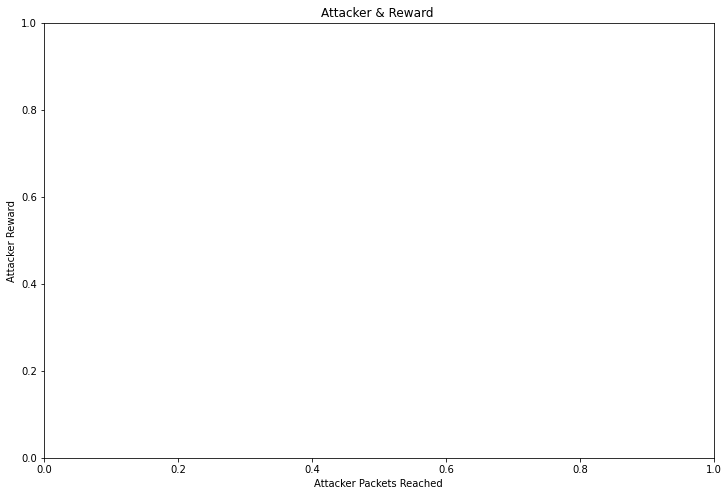

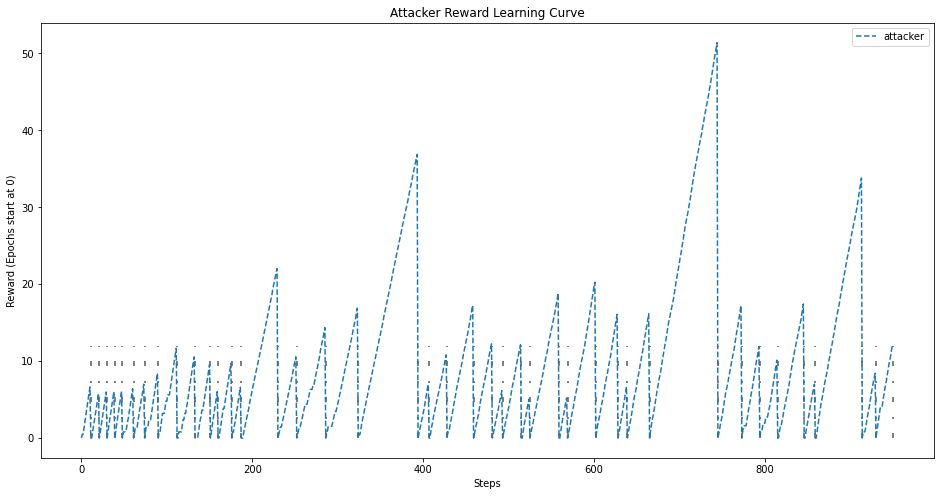

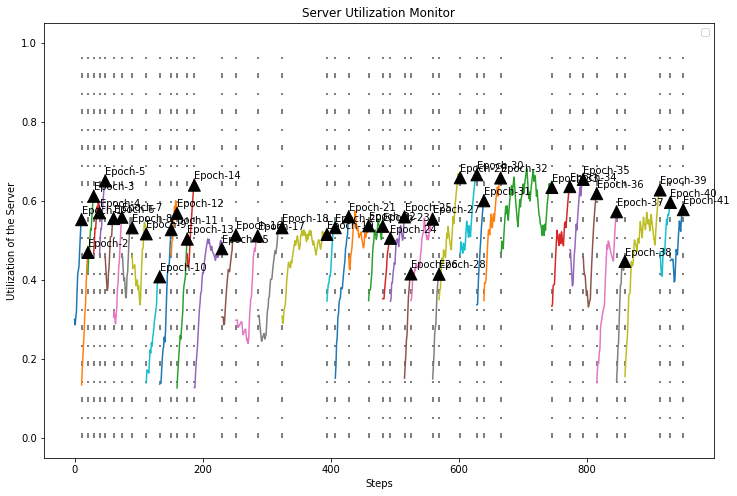

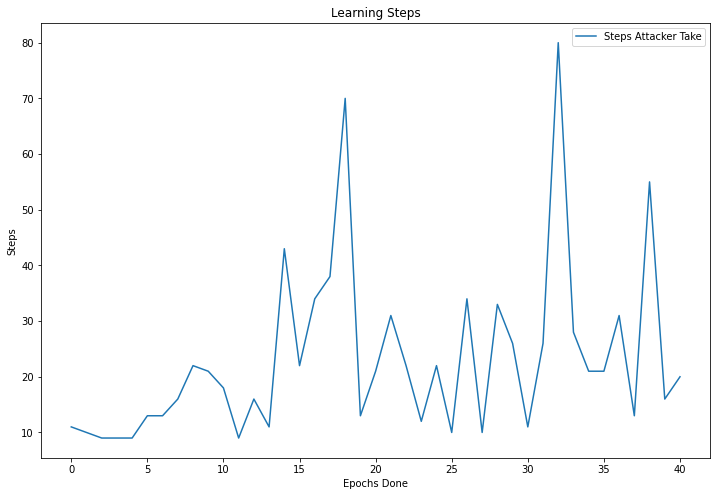

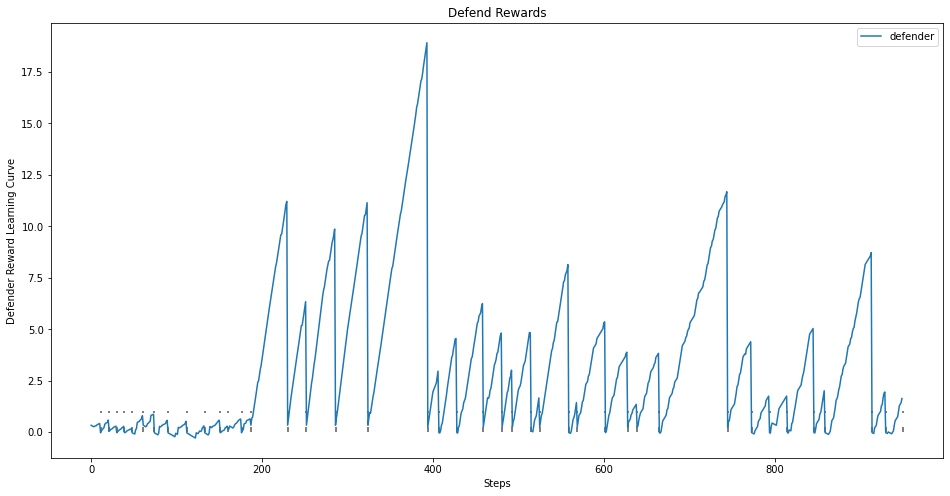

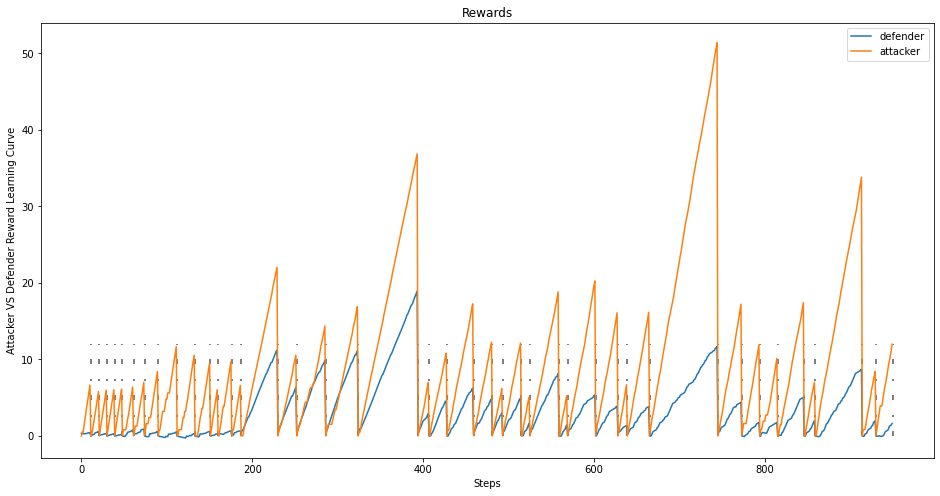

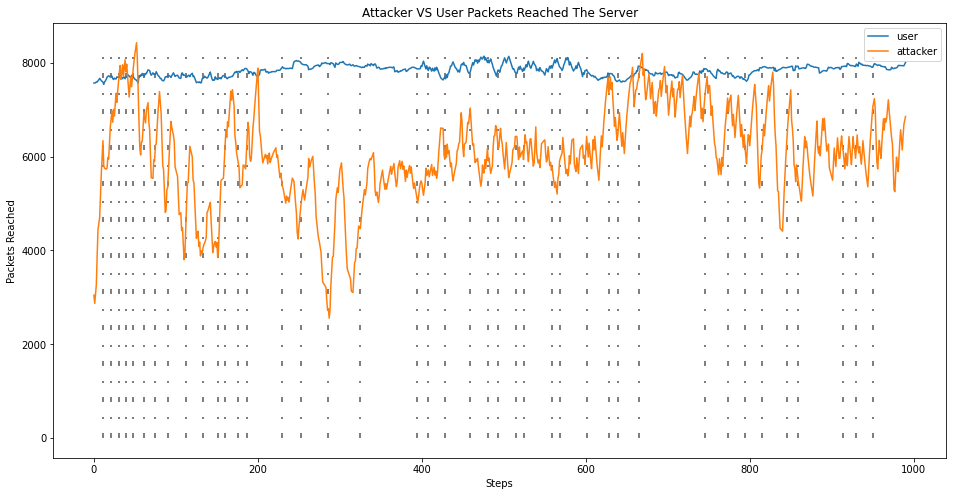

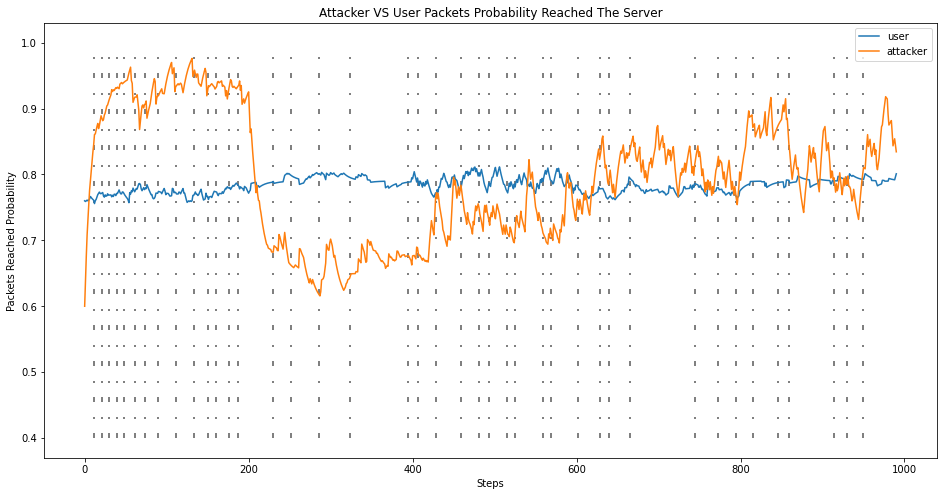

In [4]:
from gym_cyberwargame.cbw_drawer.draw_with_logger import draw
train_args = get_args()
step_per_epoch = train_args.step_per_epoch
step_per_collect = train_args.step_per_collect
draw(cbw_logger, step_per_epoch, step_per_collect, save=True, name='Training')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


a [30.06238848], b [19.59539092]
Attacker wins [2], And defender wins [0]


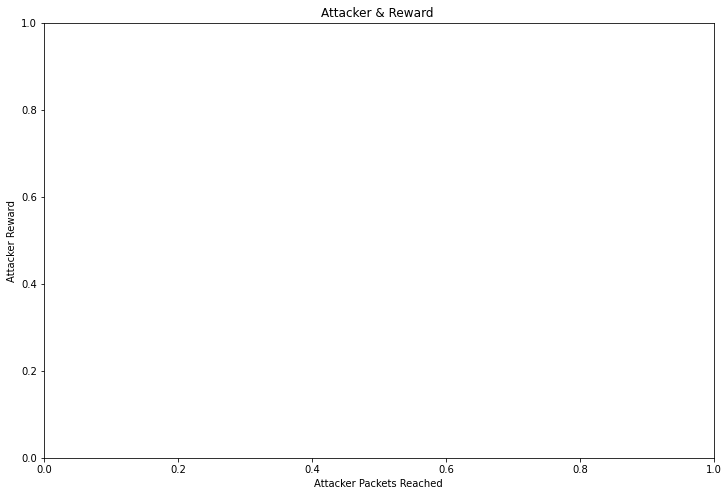

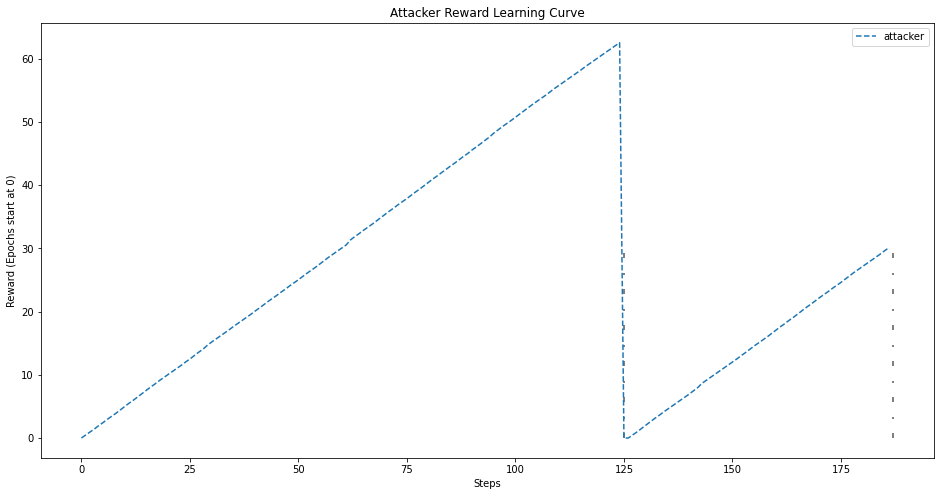

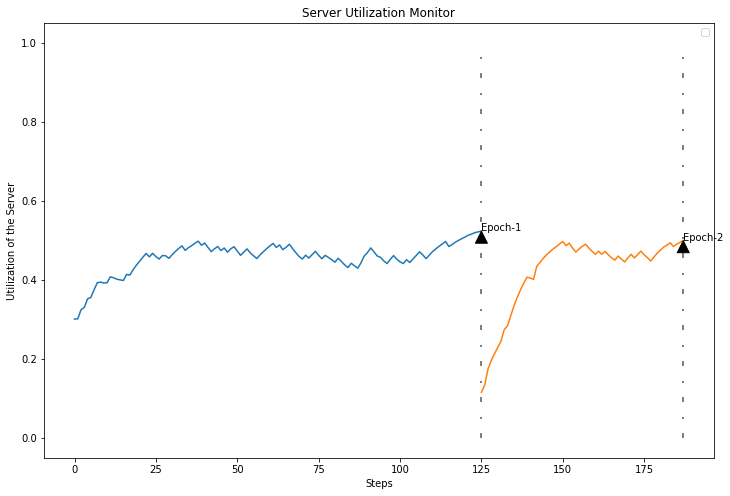

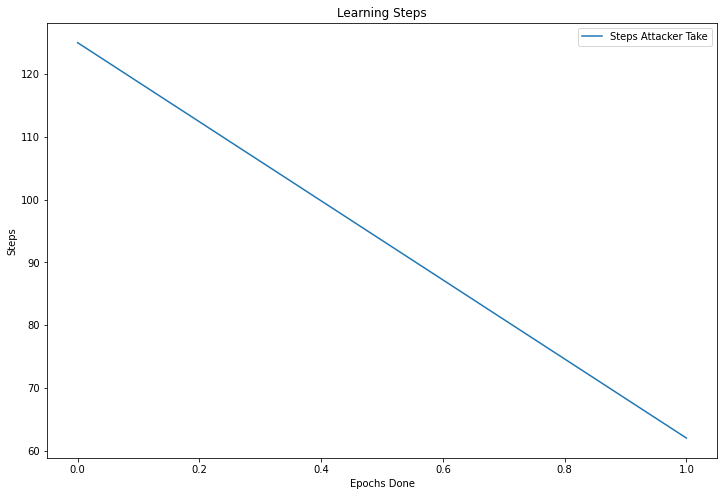

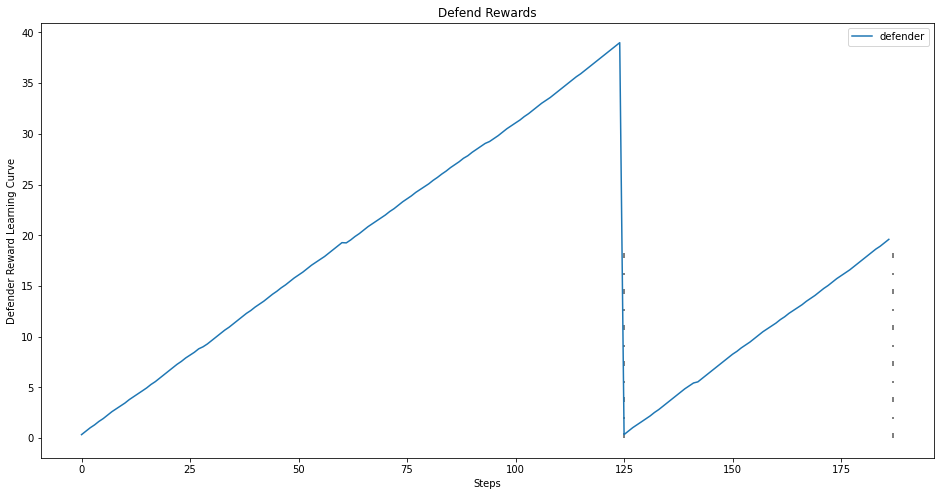

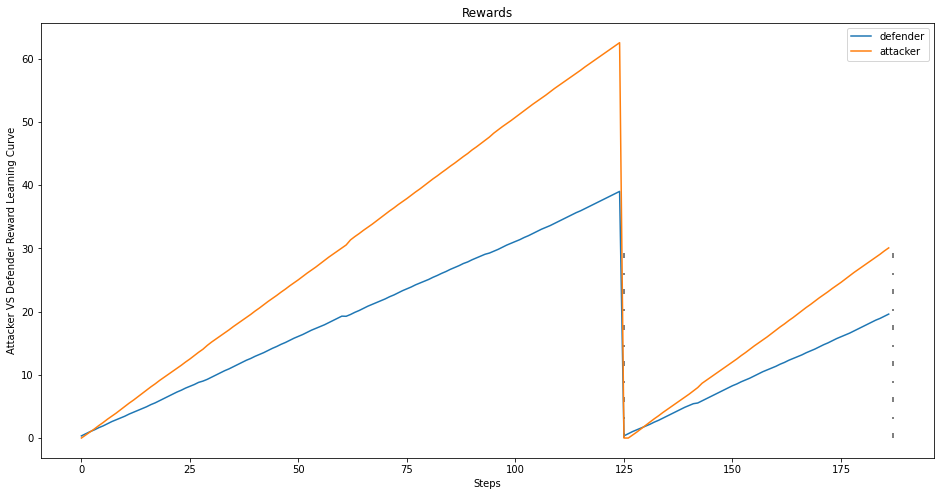

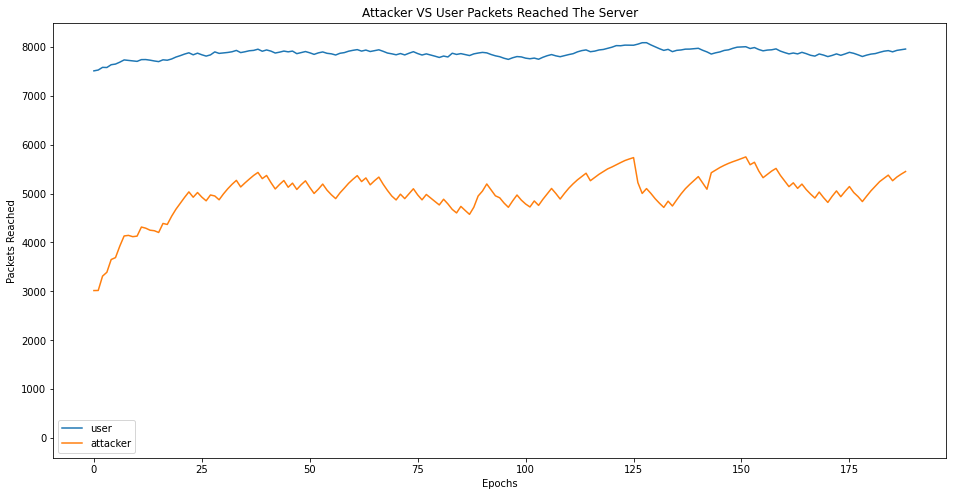

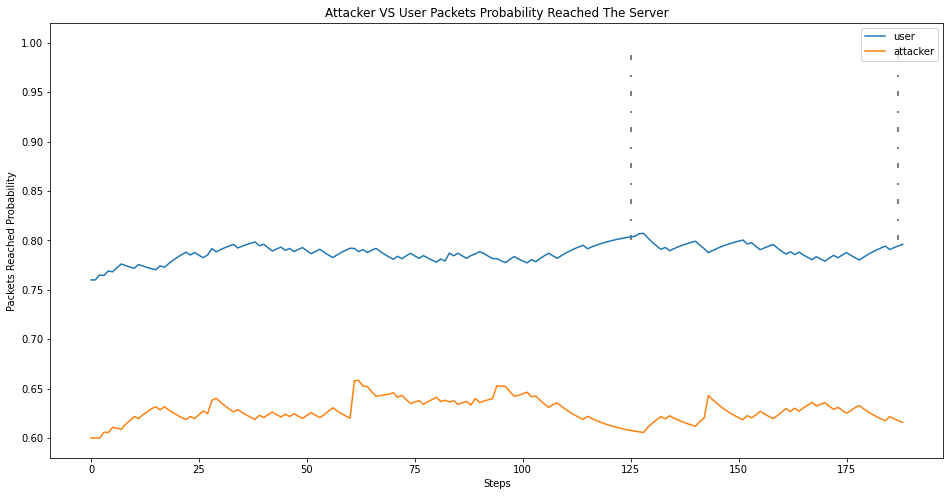

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
from scipy.interpolate import make_interp_spline

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed
"""
attacker_reached = cbw_logger.attacker_reached
user_reached = cbw_logger.user_reached
attacker_rew = cbw_logger.attack_reward
util = cbw_logger.util
defend_reward = cbw_logger.defend_reward
user_reached_p = cbw_logger.user_reached_p
attacker_reached_p = cbw_logger.attack_reached_p
a_done = cbw_logger.a_done
d_done = cbw_logger.d_done

"""
attacker_reached = cbw_logger_eval.attacker_reached
user_reached = cbw_logger_eval.user_reached
attacker_rew = cbw_logger_eval.attack_reward
util = cbw_logger_eval.util
defend_reward = cbw_logger_eval.defend_reward

a_done = cbw_logger_eval.a_done
d_done = cbw_logger_eval.d_done

# print(attacker_rew[1])
rew_array_all = []
rew_array_defend = []
user_reached_all = []
attacker_reached_all = []
user_reached_p = []
attacker_reached_p = []
user_reached_p_all = []
attacker_reached_p_all = []

user_reached_p = cbw_logger_eval.user_reached_p
attacker_reached_p = cbw_logger_eval.attack_reached_p

a_max_rew = 0
b_max_rew = 0
user_max_reached = 0
# 1. print reward graphs
fig1, ax = plt.subplots(figsize=(12,8))
# ax.plot(attacker_reached[::2], attacker_rew[::2], label='attacker')
fig2, ax2 = plt.subplots(figsize=(16,8))
fig3, ax3 = plt.subplots(figsize=(12,8))
fig4, ax4 = plt.subplots(figsize=(12,8))
fig5, ax5 = plt.subplots(figsize=(16,8))
fig6, ax6 = plt.subplots(figsize=(16,8))
fig7, ax7 = plt.subplots(figsize=(16,8))
fig8, ax8 = plt.subplots(figsize=(16,8))

for i in range(len(attacker_rew)):
    if i <= 0:
        continue
    a_max_rew = max(np.array(attacker_rew[i]))
    b_max_rew = max(np.array(defend_reward[i]))
    user_max_reached = max(np.array(user_reached[i]))

step=0
for i in range(len(attacker_rew)):
    if i <= 0:
        continue
    step += len(attacker_rew[i])
    for j in range(len(attacker_rew[i])):
        ax2.vlines(step, 0, a_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
        ax3.vlines(step, 0, 1, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
        ax5.vlines(step, 0, b_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='0.5')
        ax6.vlines(step, 0, a_max_rew, linestyle=(0, (3, 10, 1, 10)), colors='.5')
        ax7.vlines(step, 0, 1, linestyle=(0, (3, 10, 1, 10)), colors='.5')
        ax8.vlines(step, 0.8, 1, linestyle=(0, (3, 10, 1, 10)), colors='.5')
        # a_max_rew = max(attacker_rew[i][j], a_max_rew)
        rew_array_all.append(float(attacker_rew[i][j]))
        rew_array_defend.append(float(defend_reward[i][j]))

print("a {}, b {}".format(a_max_rew, b_max_rew))
# print(rew_array_defend)

# 2. set title and axis
ax.set_xlabel('Attacker Packets Reached')
ax.set_ylabel('Attacker Reward')
ax.set_title('Attacker & Reward ')

ax2.set_xlabel('Steps')
ax2.set_ylabel('Reward (Epochs start at 0)')
ax2.set_title('Attacker Reward Learning Curve')

ax3.set_xlabel('Steps')
ax3.set_ylabel('Utilization of the Server')
ax3.set_title('Server Utilization Monitor')

ax4.set_xlabel('Epochs Done')
ax4.set_ylabel('Steps')
ax4.set_title('Learning Steps')

ax5.set_xlabel('Steps')
ax5.set_ylabel('Defender Reward Learning Curve')
ax5.set_title('Defend Rewards')

ax6.set_xlabel('Steps')
ax6.set_ylabel('Attacker VS Defender Reward Learning Curve')
ax6.set_title('Rewards')

ax7.set_xlabel('Epochs')
ax7.set_ylabel('Packets Reached')
ax7.set_title('Attacker VS User Packets Reached The Server')

ax8.set_xlabel('Steps')
ax8.set_ylabel('Packets Reached Probability')
ax8.set_title('Attacker VS User Packets Probability Reached The Server')


step_take = []
# 3. Draw the reward for each epochs
for i in range(len(attacker_rew)):
    # ax.plot(attacker_reached[i], attacker_rew[i], label='attacker')
    # ax2.plot(attacker_rew[i], label='attacker')
    # Util smooth
    """
    if i>=len(attacker_rew)-5:
        util_x = np.array(range(len(util[i])))
        util_y = util[i]
        X_Y_Spline = make_interp_spline(util_x, util_y)
        X_ = np.linspace(util_x.min(), util_x.max(), 100)
        Y_ = X_Y_Spline(X_)
        ax3.plot(util_x, util_y)
    """

    if i>=1:
        util_x = np.array(range(len(util[i])))
        util_y = np.array(util[i])
        util_y_sm = smooth(util_y, 0.9)
        current_step = 0
        for i_step in step_take:
            current_step+=int(i_step)
        ax3.plot(current_step+util_x, util_y_sm)
        # if i % 10 == 0 or i == 1:
        ax3.annotate('Epoch-'+str(i), xy=(current_step+util_x[-1], util_y_sm[-1]),
                 xytext=(current_step+util_x[-1], util_y_sm[-1]), arrowprops=dict(facecolor='black', shrink=0.05))
        # ax3.plot(util_x, util_y)
        step_take.append(len(attacker_rew[i]))
        # print(len(attacker_reached[i]), attacker_reached[i])
        for itemU in user_reached[i]:
            user_reached_all.append(float(itemU))
        for itemA in attacker_reached[i]:
            attacker_reached_all.append(float(itemA))
        for up in user_reached_p[i]:
            if up != 0.0:
                user_reached_p_all.append(round(float(up), 2))
        for ap in attacker_reached_p[i]:
            if ap != 0.0:
                attacker_reached_p_all.append(round(float(ap), 2))
        # user_reached_all.append(np.asarray(user_reached[i], dtype=float))
        # attacker_reached_all.append(np.asarray(attacker_reached[i], dtype=float))

# ax.plot(attacker_reached, attacker_rew, label='defender')
# ax.plot(user_reached, defend_reward, label='defender')
# 2. print utilization graph
ax2.plot(rew_array_all, linestyle='--', label='attacker')
# ax2.plot([0]*len(rew_array_all), label='bottom')
# ax3.plot([0.4]*max(len(i) for i in attacker_rew), linestyle='solid', label='threshold')
ax4.plot(step_take, label='Steps Attacker Take')
ax5.plot(rew_array_defend, linestyle='-', label='defender')
ax6.plot(rew_array_defend, linestyle='-', label='defender')
ax6.plot(rew_array_all, label='attacker')
ax7.plot(range(len(user_reached_all)), smooth(user_reached_all, 0.9), label='user')
ax7.plot(range(len(attacker_reached_all)), smooth(attacker_reached_all, 0.9), label='attacker')

ax8.plot(range(len(user_reached_p_all)), smooth(user_reached_p_all, 0.9), label='user')
ax8.plot(range(len(attacker_reached_p_all)), smooth(attacker_reached_p_all, 0.9), label='attacker')


# ax.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax7.legend()
ax8.legend()

# Save Figure in file with format in Time-
def save_train():
    train_args = get_args()
    step_per_epoch = train_args.step_per_epoch
    step_per_collect = train_args.step_per_collect
    now_time = datetime.datetime.now()

    script_dir = os.path.dirname('train_results_RandomDefender/')
    results_dir = os.path.join(script_dir, now_time.strftime("%m-%d %H-%M")+'-epoch_step-' + str(step_per_epoch) + ' collect_step-' + str(step_per_collect)+'/')
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)

    fig1.savefig(os.path.join(results_dir, 'attacker_reward_Packets.png'))
    fig2.savefig(os.path.join(results_dir, 'attacker_reward.png'))
    fig3.savefig(os.path.join(results_dir, 'Server Utilization.png'))
    fig4.savefig(os.path.join(results_dir, 'Attacker Learning_step.png'))
    fig5.savefig(os.path.join(results_dir, 'defender_reward.png'))
    fig6.savefig(os.path.join(results_dir, 'Defender VS Attacker.png'))
    fig7.savefig(os.path.join(results_dir, 'Attacker & User Reached.png'))
    fig8.savefig(os.path.join(results_dir, 'Attacker & User Reached In Prob.png'))

print("Attacker wins {}, And defender wins {}".format(a_done[-1], d_done[-1]))
plt.show()
save_train()

### 3.2.2 For Eval

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


a [32.06233795], b [6.03978447]
Attacker wins [7], And defender wins [0]


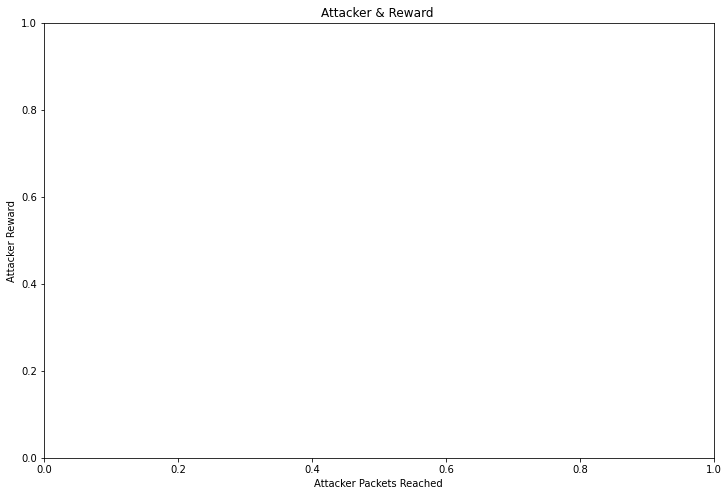

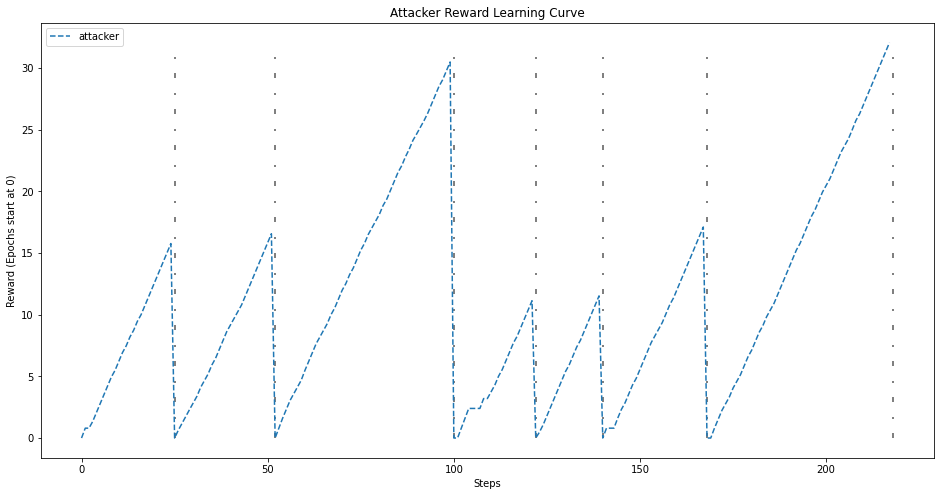

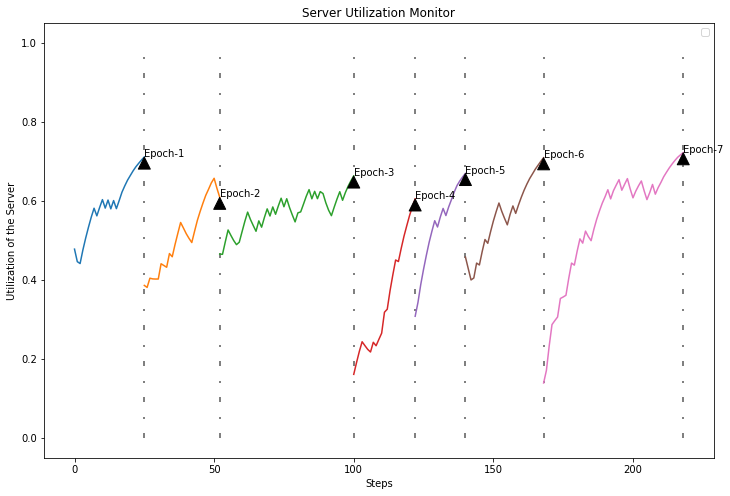

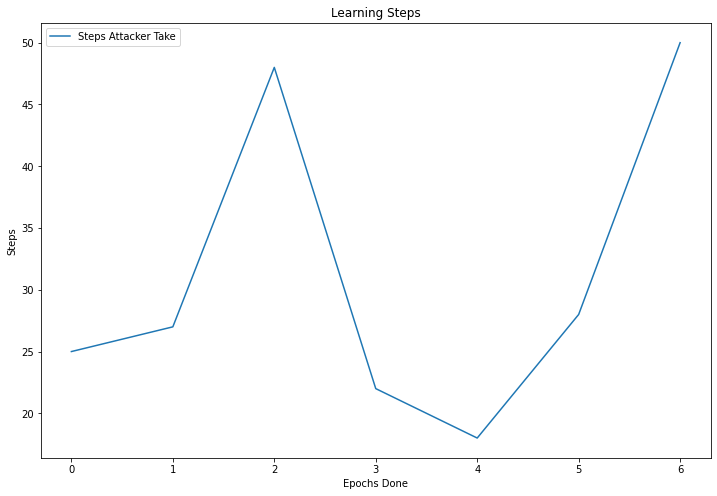

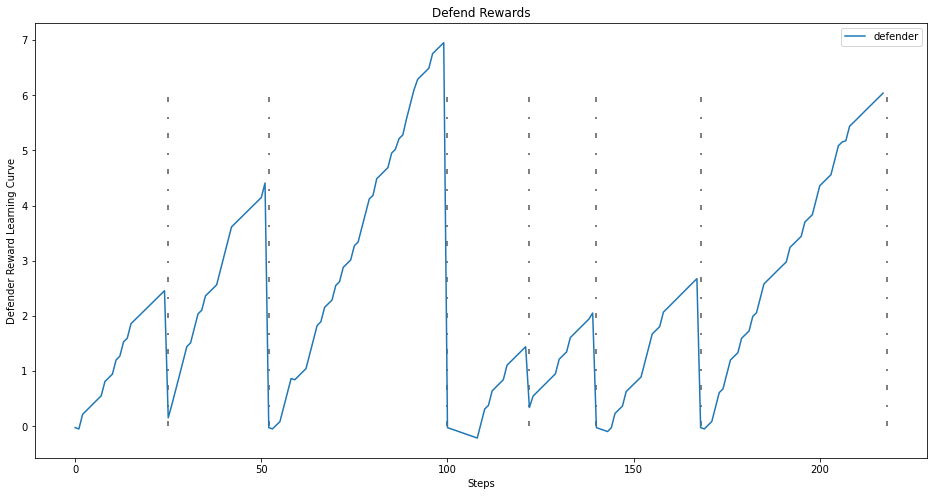

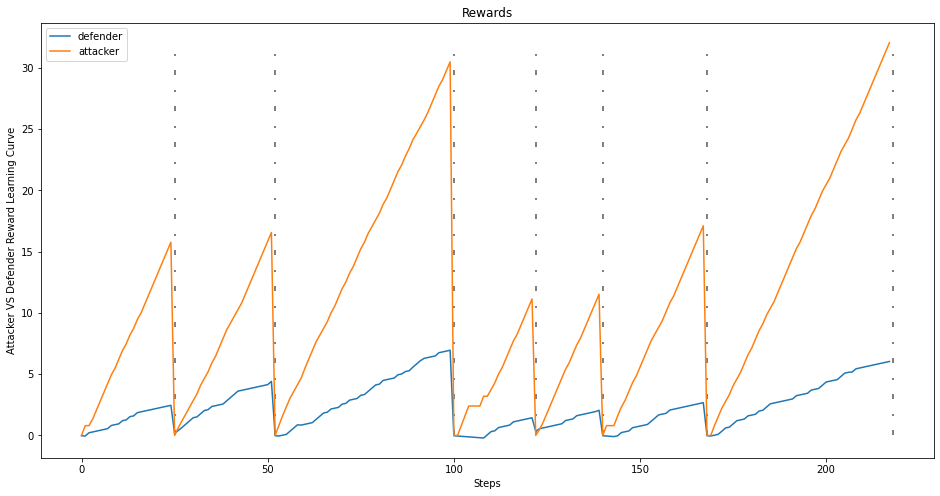

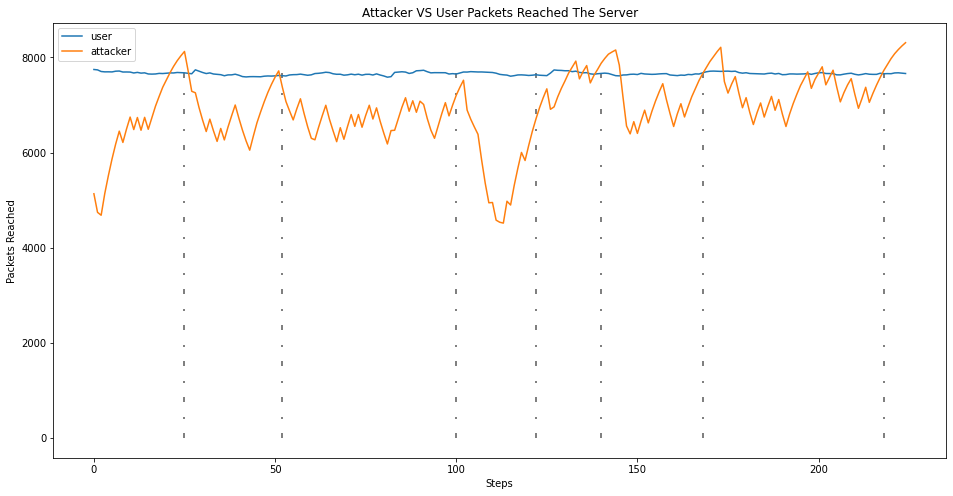

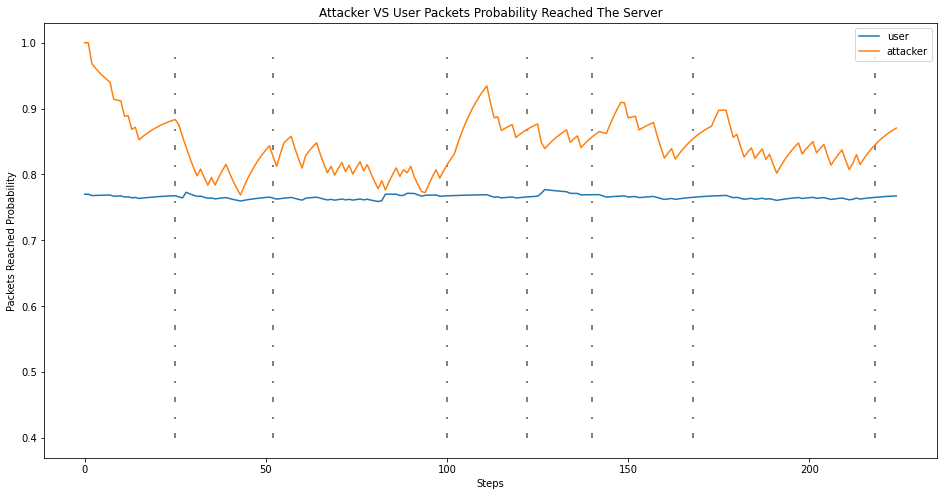

In [7]:
from gym_cyberwargame.cbw_drawer.draw_with_logger import draw
train_args = get_args()
step_per_epoch = train_args.step_per_epoch
step_per_collect = train_args.step_per_collect
draw(cbw_logger_eval, step_per_epoch, step_per_collect, save=False, name='Eval')

# Code Block for Report

## DQN agent

In [ ]:
target_update_freq = 0


net = Net(
    agent.state_shape,
    agent.action_shape,
    device=args.device
    ).to(args.device)

optim = torch.optim.Adam(net.parameters(), lr=1e-4)
agent_attacker = DQNPolicy(
    net,
    optim,
    target_update_freq=400,
    clip_loss_grad=True       # Used for Huber Loss function
    )

## BQN Agent

In [ ]:
d_net = BranchingNet(
    agent.state_shape,
    agent.num_branches,
    agent.action_per_branch,
    device=args.device,
).to(args.device)

d_optim = torch.optim.Adam(d_net.parameters(), lr=1e-4)

agent_defender = BranchingDQNPolicy(
    d_net, d_optim, target_update_freq=args.target_update_freq)

# Rllib - Failed
- Rllib is undering some migration... Can not be used

[3. 4. 3. 3. 4. 4. 3. 4. 4. 4. 4. 4. 3. 4. 2. 4. 3. 4. 3. 4. 3. 3. 4. 3.
 5. 3. 4. 4. 2. 3. 6. 2. 3. 4. 3. 5. 3. 4. 3. 4. 2. 2. 2. 3. 3. 2. 4. 5.
 2. 3. 2. 4. 5. 4. 4. 5. 3. 4. 3. 5. 4. 4. 4. 4. 4. 1. 3. 4. 2. 3. 3. 3.
 4. 5. 5. 5. 3. 3. 5. 3. 4. 2. 3. 4. 4. 4. 3. 5. 4. 4. 3. 3. 1. 3. 5. 4.
 3. 3. 4. 2.]


(array([ 2.,  0., 12.,  0., 35.,  0., 38.,  0., 12.,  1.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

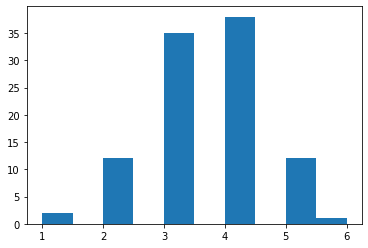

In [57]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
def get_truncated_normal(mean, sd, low, upp):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

nums = get_truncated_normal(mean=3.4, sd=1, low=0, upp=6).rvs(size=100)
nums = np.round(nums)
print(nums)
plt.hist(np.round(nums))

In [ ]:
import  datetime
now_time = datetime.datetime.now()
file_fold_name = now_time.strftime("%m-%d %H-%M")
file_fold_name += ' epoch_step-' + str(1000) + ' collect_step-' + str(100)


In [ ]:
from ray.tune.registry import register_env
# import the pettingzoo environment
from gym_cyberwargame.envs.cyberwargame_env_multiagent import env
# import rllib pettingzoo interface
from ray.rllib.env import PettingZooEnv
# define how to make the environment.
env_creator = lambda config: env()
# register that way to make the environment under an rllib name
register_env('cbw_game', lambda config: PettingZooEnv(env_creator(config)))
# now you can use `prison` as an environment
# you can pass arguments to the environment creator with the env_config option in the config
